In [140]:
# Imports
import os
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import joblib
import pickle

import torch

from darts import TimeSeries
from darts.models import  RandomForest, LinearRegressionModel,  \
                        LightGBMModel, CatBoostModel, XGBModel,  \
                        BlockRNNModel, NBEATSModel, NHiTSModel, \
                        TCNModel, TFTModel


from sklearn.svm import SVR
from sklearn.linear_model import PoissonRegressor

from darts.dataprocessing.transformers import Scaler
from darts.utils.likelihood_models import GaussianLikelihood

import warnings
warnings.filterwarnings('ignore')

# Configuration

In [141]:
prj_path = '../'
data_path = prj_path + "data/new_data/DH/squeezed/"
prj_path_opt= prj_path + "optimize_hyperparam/opt_results/"
output_process = prj_path + "data/new_data/DH/processed_data/"
output_featureselection = prj_path + "data/new_data/DH/feature_selection/"

In [142]:
all_cities = [
        'An Giang', 'BR Vũng Tàu', 'Bình Phước', 'Bình Thuận', 'Bình Định',
        'Bạc Liêu', 'Bắc Kạn', 'Bắc Giang', 'Cao Bằng', 'Cà Mau',
        'Cần Thơ', 'Gia Lai', 'Hà Giang', 'Hà Nội', 'Hà Tĩnh',
        'Hòa Bình','Hưng Yên', 'Hải Dương', 'Hải Phòng', 'Khánh Hòa', 'Kiên Giang',
        'Kon Tum', 'Lai Châu', 'Long An', 'Lào Cai', 'Lâm Đồng',
        'Lạng Sơn','Nam Định', 'Nghệ An', 'Ninh Bình', 'Ninh Thuận',
        'Phú Thọ', 'Phú Yên', 'Quảng Bình', 'Quảng Nam', 'Quảng Ngãi',
        'Quảng Ninh', 'Quảng Trị', 'Sóc Trăng', 'Sơn La', 'TT Huế',
        'Thanh Hóa', 'Thái Bình', 'Thái Nguyên', 'Tiền Giang', 'Trà Vinh',
        'Tuyên Quang', 'Tây Ninh', 'Vĩnh Phúc', 'Yên Bái', 'Điện Biên',
        'Đà Nẵng', 'Đắk Nông', 'Đắk Lắk', 'Đồng Tháp'
]
# cities = ['Hà Nội','Hải Phòng','Quảng Ninh','Nam Định','Thái Bình','Quảng Nam','Quảng Ngãi', 'Phú Yên',
#           'Ninh Thuận', 'Bình Thuận', 'Tây Ninh', 'Bình Phước', 'An Giang', 'Tiền Giang','Cần Thơ', 'Trà Vinh']

cities = [ 'Bình Phước', 'An Giang','Quảng Ninh']

In [143]:
# Set hyperparameters as args using the Configuration class
class Configuration():
    def __init__(self):
        # lấy bộ test dài 36 tháng = 3 năm
        self.test_size = 36
        # là nhìn vào dữ liệu trước 3 tháng và dự phóng        
        self.look_back = 3
        # dự phóng n-step trong 6 tháng
        self.n_predicted_period_months = 6
        self.n_features = 3
        self.seed = 42
        # mỗi phần tử x trong tập suppervise có độ lớn là 16 = 16 tháng
        self.batch_size = 16
        self.device = torch.device("cuda")
        self.epochs = 300
        #others
        self.labels = "Dengue_fever_rates"
        # Input param for Optimize Run
        self.ntry = 1
        self.njob = 1

args = Configuration()

# Seeding

In [144]:
def seed_everything(seed: int):
    import random
    import numpy as np
    import torch
    
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

seed_everything(args.seed)

# Supporting functions

In [145]:
import requests

def send_to_telegram(message):

    apiToken = '5908735099:AAGVSLrW62aXPBP-GrMvxoVgMsuJxXJpP1Q'
    chatID = '@ptn_announcement'
    apiURL = f'https://api.telegram.org/bot{apiToken}/sendMessage'

    try:
        response = requests.post(apiURL, json={'chat_id': chatID, 'text': message})
        print(response.text)
    except Exception as e:
        message_error = "Bị lỗi rùi: "+str(e)
        response = requests.post(apiURL, json={'chat_id': chatID, 'text': message_error})
        print(e)

In [146]:
def get_dict_all_city_data():
  cities_data = {}  
  for city in cities:
    city_result = pd.read_excel(prj_path+'data/new_data/DH/squeezed/squeezed_'+city+'.xlsx')  
    """Get all data from all city in 1997 - 2016""" 
    city_result = city_result.loc[city_result['year_month'] < '2017-1-1'] 
    cities_data[city] = city_result
  return cities_data

In [147]:
# Define data (pre-)processing functions
# modification
def get_city_data(city_name, dict_full_data):
    """Returns Diarrhoea rate and climate data""" 
    city_data = dict_full_data[city_name].drop(columns=['Diarrhoea_cases','Diarrhoea_rates', 'province',
                                                        'Influenza_rates','Influenza_cases',
                                                        'Dengue_fever_cases', 'year', 'month'], 
                                                                  axis=1, 
                                                                  inplace=False)    
    return city_data

def convert_to_stationary(city_data):
    """Subtracts previous value for all cols except disease rates"""
    for col_name in city_data.columns:
        if col_name != 'Diarrhoea_rates':
            try:
                city_data[col_name] = city_data[col_name] - city_data[col_name].shift()
            except:
                print(col_name)
    return city_data

def impute_missing_value(city_data):
    """
    Imputes 0 for first 12 months, 
    last year's value for months 12-24, 
    and minimum value of last two years for months 25+
    """
    for col in city_data.columns:
        for index in range(len(city_data[col])):
            if np.isnan(city_data[col].iloc[index]):
                if index < 12:
                    city_data[col].iloc[index] = 0
                elif index >= 12 and index <= 24:
                    city_data[col].iloc[index] = city_data[col].iloc[index - 12]
                else:
                    city_data[col].iloc[index] = min(city_data[col].iloc[index - 12], city_data[col].iloc[index - 24])
    return city_data

In [148]:
def clean_full_data(dict_full_data):
    climate_and_disease_feats = ['Total_Evaporation',
       'Total_Rainfall', 'Max_Daily_Rainfall', 'n_raining_days',
       'Average_temperature', 'Max_Average_Temperature',
       'Min_Average_Temperature', 'Max_Absolute_Temperature',
       'Min_Absolute_Temperature', 'Average_Humidity', 'Min_Humidity',
       'n_hours_sunshine', 'Dengue_fever_rates']
    for city in cities:
        city_data = get_city_data(city_name=city,dict_full_data = dict_full_data)
        city_data_features = city_data[climate_and_disease_feats]
        city_data_features = impute_missing_value(city_data_features)
        city_data_features = convert_to_stationary(city_data_features)
        city_data_features.dropna(inplace=True)
        city_data_features.loc[:, "year_month"] = city_data["year_month"]
        dict_full_data[city] = city_data_features
    return dict_full_data


In [149]:
def to_supervised(data,  d_out, d_in, features_list=[]):
    """
    Frames time-series as supervised learning dataset.
    
    Args:
      d_in: lookback window
      d_out: number of predicted months
      features_list: list of all features **where last col is the disease incidence**

    Returns:
      Numpy arrays of disease incidence (y) and other predictors (X)
    """
    X, y = list(), list()
    for index, _ in enumerate(data):
        in_end = index + d_in
        out_end = in_end + d_out
        if out_end <= len(data):
            if len(features_list) == 0 :
                X.append(data[index: in_end, :-1])
            else:
                X.append(data[index: in_end, features_list])
            y.append(data[out_end-1: out_end, -1])
    return np.array(X), np.array(y).reshape(len(y))

In [150]:
def train_and_evaluate(df_train, df_eval, model, feature_list , labels, scaler, is_dl_algo,is_sklearn_model,nstep):
  """
  $df: pandas.DataFrame object containing data for training and testing model:
  $model: darts model object
  $feature_list: Names of the features used as model input
  $label: the value the model will be trained to predict
  $scaler: scaler object. Note: the scaler will be fitted on training data and applied to test data
  $lags: how much to look back into the past to output prediction
  $split_index: the point at which to divide train and test_data

  """

  if is_dl_algo == 1:
    print("🍋")
  else:
      if is_sklearn_model == 1:
        train = df_train[feature_list+[args.labels]].iloc[:,:].to_numpy()
        df_eval = df_eval[-args.test_size - args.look_back-(nstep - 1): ] #Fit size of the test by step
        test = df_eval[feature_list+[args.labels]].iloc[:,:].to_numpy()
        x_train,y_train = to_supervised(train, d_out=nstep, d_in=args.look_back )
        x_train = x_train.reshape(len(x_train),x_train.shape[1]*x_train.shape[2])
        x_test,y_test = to_supervised(test, d_out=nstep, d_in=args.look_back )
        x_test = x_test.reshape(len(x_test),x_test.shape[1]*x_test.shape[2])

        model = model.fit(x_train,y_train)
        prediction = model.predict(x_test)
        
        print("🐹Len(prediction):",len(prediction))
        df_eval = df_eval[-args.test_size:]
        y_true = df_eval[labels].values

        df_eval_pred_inverse = df_eval[-args.test_size:]
        df_eval_pred_inverse[labels]= prediction
        y_pred = scaler.inverse_transform(df_eval_pred_inverse.iloc[:,:-1])[:,[-1]].reshape(len(prediction))  
      else:
        x_train = TimeSeries.from_dataframe(df_train, "year_month", feature_list)
        y_train = TimeSeries.from_dataframe(df_train, "year_month", labels)

        df_eval = df_eval[-args.test_size - args.look_back-(nstep - 1): ]

        x_test = TimeSeries.from_dataframe(df_eval, "year_month", feature_list)
        y_test = TimeSeries.from_dataframe(df_eval, "year_month", labels)

        model.fit(y_train, past_covariates = x_train)

        prediction = model.predict(args.test_size, past_covariates = x_test, num_samples=1)

        df_eval = df_eval[-args.test_size:]
        y_true = df_eval[labels].values
        df_eval[labels]= np.array(prediction._xa).squeeze()
        y_pred = scaler.inverse_transform(df_eval.iloc[:,:-1])[:,[-1]].reshape(len(prediction))


  mse = mean_squared_error(y_true, y_pred)
  mae = mean_absolute_error(y_true, y_pred)
  rmse = mse**0.5
  mape = mean_absolute_percentage_error(y_true, y_pred)
  print(f"mean_squared_error: {mse:.4f}")
  print(f"rmse: {rmse}")
  print(f"mape: {mape}")
  return model, y_true, y_pred, mse, mae, rmse, mape

In [151]:
def output_prediction_for_location(df_train, df_eval, model, location, feature_list, 
                                                labels, scaler, is_dl_algo, is_sklearn_model ,nstep):
    """train and generate prediction for a province
    df: DataFrame object containing features and label(s) for training model
    localtion: location_name
    feature_list: list of features used as model input,  must be among the column names of df
    labels: the values model will be trained to predict
    scaler: sklearn scaler object
    lags: how long into the past to look back when making prediction
    split_index: the point at which to divide data into the train and test subsets.
    """
    model, y_true, prediction_inverse, mse, mae, rmse, mape = train_and_evaluate(df_train, df_eval, model, feature_list, labels, scaler,is_dl_algo, is_sklearn_model,nstep)
    df_prediction = pd.DataFrame({"Date": df_eval["year_month"][-len(prediction_inverse):],
                                  "Observed": y_true[-len(prediction_inverse):],
                                  f"{nstep}-month": prediction_inverse})
    

    df_prediction["City"] = location
    df_prediction[f"RMSE_{nstep}-month"] = rmse
    df_prediction[f"MAE_{nstep}-month"] = mae
    df_prediction[f"MAPE_{nstep}-month"] = mape
    df_prediction[f"MSE_{nstep}-month"] = mse

    df_compare_test_predict = pd.DataFrame({'y_true':y_true, 'y_pred':prediction_inverse})
    df_compare_test_predict.plot()
    plt.legend()
    plt.title(f"{nstep}step_{type(model).__name__}_DF_{location}")
    plt.savefig(f"./predict_results/{nstep}step_{type(model).__name__}_DF_{location}_tkde.png", dpi=300)
    plt.show()

    temp_rs = f"{rmse},{mae},{mape},{mse}"
    print("rmse,mae,mape,mse")
    print(temp_rs)
    
    return df_prediction, model

In [152]:
def getDataWithSelectedFeature(city, next_predicted_month):
  selected_feature = []
  df = pd.read_csv(output_featureselection+str(next_predicted_month)+"step_feature_selection_3_most.csv")
  for row in range(len(df)):
    if (df["City"][row] == city):
      selected_feature.append(df["1st_Feature"][row])
      selected_feature.append(df["2nd_Feature"][row])
      selected_feature.append(df["3rd_Feature"][row])
  return selected_feature

In [153]:
def getHyperParams(model_name, city, nstep):
  folder_path = f'../optimize_hyperparam/opt_results/opt_res_ml_26102023/{model_name}/'
  file_path = folder_path+ f'261023_DF_opt_hyperparam_{model_name}_{nstep}-nstep.xlsx'
  df_optimized = pd.read_excel(file_path)
  display(df_optimized)
  df_optimized_params = df_optimized.loc[(df_optimized['City'] == city)]
  return df_optimized_params

# Training

✨✨✨✨✨✨✨✨1✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨PoissonRegressor✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,max_iter,fit_intercept,alpha
0,Bình Phước,PoissonRegressor,18.811761,1,156,False,1.418109e-03
1,An Giang,PoissonRegressor,33.159301,1,175,False,8.940646e-01
2,Quảng Ninh,PoissonRegressor,1.852807,1,77,False,5.453486e-08


,Total_Evaporation,Total_Rainfall,Max_Daily_Rainfall,n_raining_days,Average_temperature,Max_Average_Temperature,Min_Average_Temperature,Max_Absolute_Temperature,Min_Absolute_Temperature,Average_Humidity,Min_Humidity,n_hours_sunshine,Dengue_fever_rates,year_month
5,0.778270,0.670609,0.764260,0.500000,0.576923,0.704918,0.351351,0.507692,0.401869,0.365854,0.325,0.906542,13.033561,2013-10-31
6,0.652624,0.138426,0.140489,0.500000,0.474359,0.573770,0.297297,0.569231,0.383178,0.292683,0.575,0.500000,10.861301,2013-11-30
7,0.793053,0.501939,0.438325,0.500000,0.307692,0.377049,0.162162,0.476923,0.289720,0.414634,0.300,0.542056,9.666558,2013-12-31
8,0.688101,0.408879,0.463613,0.500000,0.461539,0.622951,0.243243,0.692308,0.383178,0.219512,0.275,0.771028,2.895442,2014-01-31
9,0.461936,0.499031,0.483282,0.500000,0.717949,0.885246,0.554054,0.738461,0.644860,0.634146,0.575,0.322430,1.501340,2014-02-28
10,0.852180,0.504847,0.491711,1.305556,0.794872,0.606557,0.770270,1.107692,0.775701,0.414634,0.400,0.691589,1.823056,2014-03-31
11,0.150037,0.786933,0.736162,-0.138889,0.487179,0.639344,0.635135,0.261539,0.616822,0.560976,0.950,0.336449,1.072386,2014-04-30
12,0.386548,0.510663,0.410228,0.333333,0.897436,0.540984,0.486486,0.569231,0.626168,0.512195,0.575,0.663551,2.680965,2014-05-31
13,0.660015,0.510663,0.401798,0.888889,-0.012821,0.131148,0.310811,0.353846,0.514019,0.634146,0.675,-0.028037,2.680965,2014-06-30
14,0.467849,0.625049,0.592863,0.722222,0.423077,0.393443,0.324324,0.400000,0.523365,0.512195,0.575,0.476635,6.219839,2014-07-31


🐹Len(prediction): 36
mean_squared_error: 331.3311
rmse: 18.20250132037569
mape: 3.8923753256775715


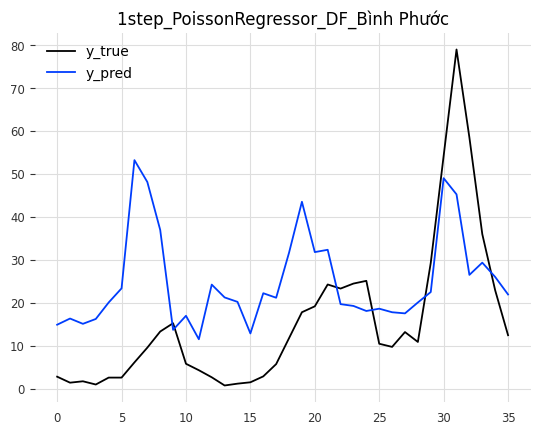

rmse,mae,mape,mse
18.20250132037569,14.975090389096554,3.8923753256775715,331.3310543182787
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,max_iter,fit_intercept,alpha
0,Bình Phước,PoissonRegressor,18.811761,1,156,False,1.418109e-03
1,An Giang,PoissonRegressor,33.159301,1,175,False,8.940646e-01
2,Quảng Ninh,PoissonRegressor,1.852807,1,77,False,5.453486e-08


,Total_Evaporation,Total_Rainfall,Max_Daily_Rainfall,n_raining_days,Average_temperature,Max_Average_Temperature,Min_Average_Temperature,Max_Absolute_Temperature,Min_Absolute_Temperature,Average_Humidity,Min_Humidity,n_hours_sunshine,Dengue_fever_rates,year_month
5,0.465517,0.474796,0.475610,0.560976,0.548387,0.388060,0.479452,0.3125,0.524272,0.35,0.394737,0.830,6.315887,2013-10-31
6,0.500000,0.354905,0.244774,0.560976,0.612903,0.388060,0.534247,0.4125,0.660194,0.25,0.394737,0.650,9.706033,2013-11-30
7,0.574713,0.453678,0.523519,0.560976,0.161290,0.029851,0.150685,0.4000,0.165048,0.25,0.552632,0.610,9.055868,2013-12-31
8,0.402299,0.435286,0.275261,0.560976,0.532258,0.447761,0.136986,0.4125,0.417476,0.25,0.236842,0.625,4.545876,2014-01-31
9,0.327586,0.464578,0.423345,0.560976,0.725807,0.582090,0.890411,0.6250,0.912621,0.50,0.763158,0.590,2.180165,2014-02-28
10,0.568966,0.465259,0.427700,1.268293,0.903226,0.731343,0.808219,0.8000,0.737864,0.25,0.315790,0.670,1.994619,2014-03-31
11,0.402299,0.541553,0.567073,0.000000,0.774193,0.507463,0.739726,0.5375,0.786408,0.45,0.473684,0.375,3.942852,2014-04-30
12,0.373563,0.473433,0.554007,0.414634,0.741935,0.447761,0.698630,0.4500,0.747573,0.60,0.657895,0.585,3.989238,2014-05-31
13,0.431034,0.442779,0.253484,0.902439,0.370968,0.044776,0.452055,0.4000,0.514563,0.70,0.657895,0.120,3.571760,2014-06-30
14,0.580460,0.444823,0.388502,0.926829,0.500000,0.328358,0.452055,0.3625,0.640777,0.35,0.368421,0.520,3.293441,2014-07-31


🐹Len(prediction): 36
mean_squared_error: 1365.1375
rmse: 36.947766902086244
mape: 6.2362022163508986


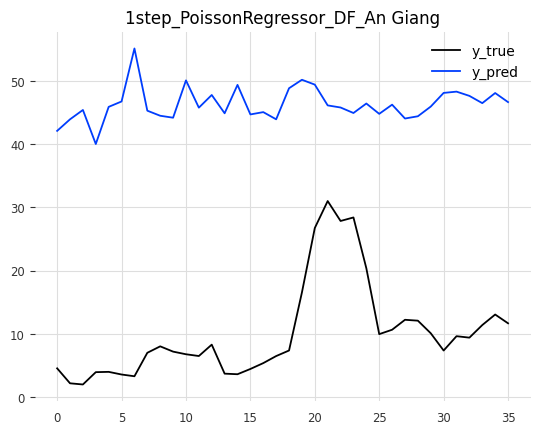

rmse,mae,mape,mse
36.947766902086244,36.11598306186578,6.2362022163508986,1365.1374790508996
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,max_iter,fit_intercept,alpha
0,Bình Phước,PoissonRegressor,18.811761,1,156,False,1.418109e-03
1,An Giang,PoissonRegressor,33.159301,1,175,False,8.940646e-01
2,Quảng Ninh,PoissonRegressor,1.852807,1,77,False,5.453486e-08


,Total_Evaporation,Total_Rainfall,Max_Daily_Rainfall,n_raining_days,Average_temperature,Max_Average_Temperature,Min_Average_Temperature,Max_Absolute_Temperature,Min_Absolute_Temperature,Average_Humidity,Min_Humidity,n_hours_sunshine,Dengue_fever_rates,year_month
5,0.872138,0.158179,0.430626,0.585366,0.392435,0.480349,0.395112,0.522565,0.314570,0.077299,0.143646,0.680955,1.852632,2013-10-31
6,0.246977,0.653588,0.863790,0.585366,0.286052,0.211790,0.466395,0.434679,0.509934,0.491331,0.491713,0.315983,0.926316,2013-11-30
7,0.529972,0.378527,0.302030,0.585366,0.000000,0.144105,0.000000,0.118765,0.157285,0.219253,0.237569,0.794856,1.431579,2013-12-31
8,0.447132,0.477459,0.535533,0.975610,0.602837,0.561135,0.655805,0.539192,0.582781,0.562308,0.381215,0.489896,0.000000,2014-01-31
9,0.206329,0.547911,0.604907,0.939024,0.529551,0.355895,0.665988,0.676960,0.637417,0.656944,0.607735,0.161666,0.250125,2014-02-28
10,0.308721,0.560277,0.603215,0.646342,0.728132,0.668122,0.778004,0.676960,0.892384,0.692433,0.933702,0.471525,0.000000,2014-03-31
11,0.638024,0.559903,0.648900,0.768293,0.867612,0.868996,0.883910,0.714964,0.870861,0.266571,0.270718,0.597673,0.333500,2014-04-30
12,0.756367,0.465842,0.550761,0.658537,0.770686,0.768559,0.708758,0.988124,0.624172,0.171935,0.265193,1.088794,0.416875,2014-05-31
13,0.486236,0.839835,0.584602,0.097561,0.572104,0.628821,0.621181,0.555820,0.725166,0.432184,0.386740,0.478873,0.667000,2014-06-30
14,0.468227,0.553157,0.692047,0.829268,0.505910,0.475982,0.539715,0.532066,0.619205,0.420354,0.425414,0.591549,0.000000,2014-07-31


🐹Len(prediction): 36
mean_squared_error: 3.9639
rmse: 1.9909549972405334
mape: 1958087073503623.5


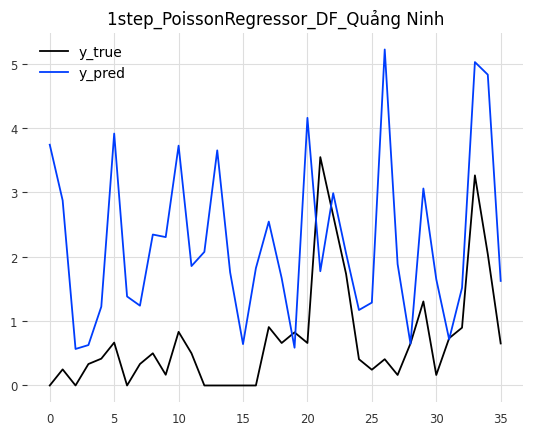

rmse,mae,mape,mse
1.9909549972405334,1.6211421418791907,1958087073503623.5,3.9639018010370526
✨✨✨✨✨✨✨✨SVMRBF✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,max_iter,kernel,epsilon
0,Bình Phước,SVMRBF,14.904547,1,144,rbf,1.176130e-02
1,An Giang,SVMRBF,10.404727,1,65,rbf,1.326161e-07
2,Quảng Ninh,SVMRBF,2.371283,1,153,rbf,4.559729e-06


,Total_Evaporation,Total_Rainfall,Max_Daily_Rainfall,n_raining_days,Average_temperature,Max_Average_Temperature,Min_Average_Temperature,Max_Absolute_Temperature,Min_Absolute_Temperature,Average_Humidity,Min_Humidity,n_hours_sunshine,Dengue_fever_rates,year_month
5,0.778270,0.670609,0.764260,0.500000,0.576923,0.704918,0.351351,0.507692,0.401869,0.365854,0.325,0.906542,13.033561,2013-10-31
6,0.652624,0.138426,0.140489,0.500000,0.474359,0.573770,0.297297,0.569231,0.383178,0.292683,0.575,0.500000,10.861301,2013-11-30
7,0.793053,0.501939,0.438325,0.500000,0.307692,0.377049,0.162162,0.476923,0.289720,0.414634,0.300,0.542056,9.666558,2013-12-31
8,0.688101,0.408879,0.463613,0.500000,0.461539,0.622951,0.243243,0.692308,0.383178,0.219512,0.275,0.771028,2.895442,2014-01-31
9,0.461936,0.499031,0.483282,0.500000,0.717949,0.885246,0.554054,0.738461,0.644860,0.634146,0.575,0.322430,1.501340,2014-02-28
10,0.852180,0.504847,0.491711,1.305556,0.794872,0.606557,0.770270,1.107692,0.775701,0.414634,0.400,0.691589,1.823056,2014-03-31
11,0.150037,0.786933,0.736162,-0.138889,0.487179,0.639344,0.635135,0.261539,0.616822,0.560976,0.950,0.336449,1.072386,2014-04-30
12,0.386548,0.510663,0.410228,0.333333,0.897436,0.540984,0.486486,0.569231,0.626168,0.512195,0.575,0.663551,2.680965,2014-05-31
13,0.660015,0.510663,0.401798,0.888889,-0.012821,0.131148,0.310811,0.353846,0.514019,0.634146,0.675,-0.028037,2.680965,2014-06-30
14,0.467849,0.625049,0.592863,0.722222,0.423077,0.393443,0.324324,0.400000,0.523365,0.512195,0.575,0.476635,6.219839,2014-07-31


🐹Len(prediction): 36
mean_squared_error: 403.9671
rmse: 20.098932892084235
mape: 4.416511320311619


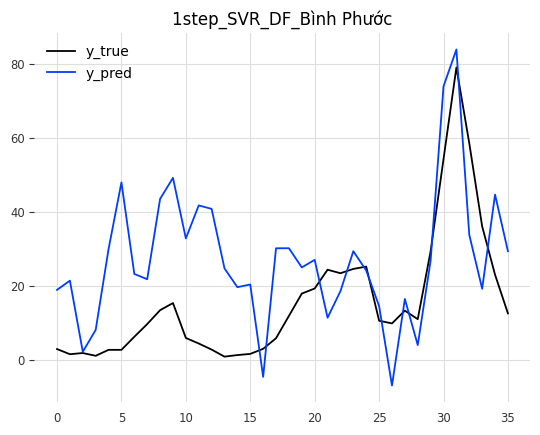

rmse,mae,mape,mse
20.098932892084235,16.638985438729755,4.416511320311619,403.9671034005056
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,max_iter,kernel,epsilon
0,Bình Phước,SVMRBF,14.904547,1,144,rbf,1.176130e-02
1,An Giang,SVMRBF,10.404727,1,65,rbf,1.326161e-07
2,Quảng Ninh,SVMRBF,2.371283,1,153,rbf,4.559729e-06


,Total_Evaporation,Total_Rainfall,Max_Daily_Rainfall,n_raining_days,Average_temperature,Max_Average_Temperature,Min_Average_Temperature,Max_Absolute_Temperature,Min_Absolute_Temperature,Average_Humidity,Min_Humidity,n_hours_sunshine,Dengue_fever_rates,year_month
5,0.465517,0.474796,0.475610,0.560976,0.548387,0.388060,0.479452,0.3125,0.524272,0.35,0.394737,0.830,6.315887,2013-10-31
6,0.500000,0.354905,0.244774,0.560976,0.612903,0.388060,0.534247,0.4125,0.660194,0.25,0.394737,0.650,9.706033,2013-11-30
7,0.574713,0.453678,0.523519,0.560976,0.161290,0.029851,0.150685,0.4000,0.165048,0.25,0.552632,0.610,9.055868,2013-12-31
8,0.402299,0.435286,0.275261,0.560976,0.532258,0.447761,0.136986,0.4125,0.417476,0.25,0.236842,0.625,4.545876,2014-01-31
9,0.327586,0.464578,0.423345,0.560976,0.725807,0.582090,0.890411,0.6250,0.912621,0.50,0.763158,0.590,2.180165,2014-02-28
10,0.568966,0.465259,0.427700,1.268293,0.903226,0.731343,0.808219,0.8000,0.737864,0.25,0.315790,0.670,1.994619,2014-03-31
11,0.402299,0.541553,0.567073,0.000000,0.774193,0.507463,0.739726,0.5375,0.786408,0.45,0.473684,0.375,3.942852,2014-04-30
12,0.373563,0.473433,0.554007,0.414634,0.741935,0.447761,0.698630,0.4500,0.747573,0.60,0.657895,0.585,3.989238,2014-05-31
13,0.431034,0.442779,0.253484,0.902439,0.370968,0.044776,0.452055,0.4000,0.514563,0.70,0.657895,0.120,3.571760,2014-06-30
14,0.580460,0.444823,0.388502,0.926829,0.500000,0.328358,0.452055,0.3625,0.640777,0.35,0.368421,0.520,3.293441,2014-07-31


🐹Len(prediction): 36
mean_squared_error: 376.7437
rmse: 19.40988638619612
mape: 2.427781620900398


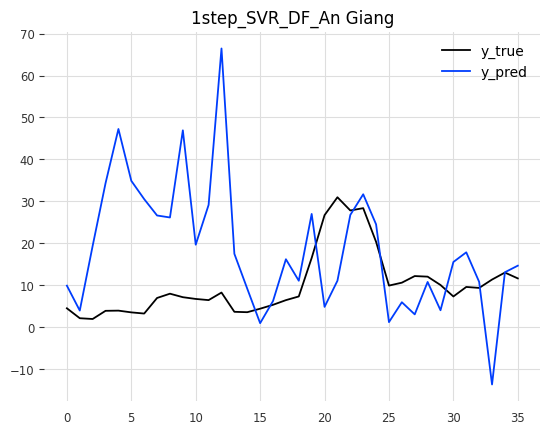

rmse,mae,mape,mse
19.40988638619612,13.944070897562336,2.427781620900398,376.7436895250415
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,max_iter,kernel,epsilon
0,Bình Phước,SVMRBF,14.904547,1,144,rbf,1.176130e-02
1,An Giang,SVMRBF,10.404727,1,65,rbf,1.326161e-07
2,Quảng Ninh,SVMRBF,2.371283,1,153,rbf,4.559729e-06


,Total_Evaporation,Total_Rainfall,Max_Daily_Rainfall,n_raining_days,Average_temperature,Max_Average_Temperature,Min_Average_Temperature,Max_Absolute_Temperature,Min_Absolute_Temperature,Average_Humidity,Min_Humidity,n_hours_sunshine,Dengue_fever_rates,year_month
5,0.872138,0.158179,0.430626,0.585366,0.392435,0.480349,0.395112,0.522565,0.314570,0.077299,0.143646,0.680955,1.852632,2013-10-31
6,0.246977,0.653588,0.863790,0.585366,0.286052,0.211790,0.466395,0.434679,0.509934,0.491331,0.491713,0.315983,0.926316,2013-11-30
7,0.529972,0.378527,0.302030,0.585366,0.000000,0.144105,0.000000,0.118765,0.157285,0.219253,0.237569,0.794856,1.431579,2013-12-31
8,0.447132,0.477459,0.535533,0.975610,0.602837,0.561135,0.655805,0.539192,0.582781,0.562308,0.381215,0.489896,0.000000,2014-01-31
9,0.206329,0.547911,0.604907,0.939024,0.529551,0.355895,0.665988,0.676960,0.637417,0.656944,0.607735,0.161666,0.250125,2014-02-28
10,0.308721,0.560277,0.603215,0.646342,0.728132,0.668122,0.778004,0.676960,0.892384,0.692433,0.933702,0.471525,0.000000,2014-03-31
11,0.638024,0.559903,0.648900,0.768293,0.867612,0.868996,0.883910,0.714964,0.870861,0.266571,0.270718,0.597673,0.333500,2014-04-30
12,0.756367,0.465842,0.550761,0.658537,0.770686,0.768559,0.708758,0.988124,0.624172,0.171935,0.265193,1.088794,0.416875,2014-05-31
13,0.486236,0.839835,0.584602,0.097561,0.572104,0.628821,0.621181,0.555820,0.725166,0.432184,0.386740,0.478873,0.667000,2014-06-30
14,0.468227,0.553157,0.692047,0.829268,0.505910,0.475982,0.539715,0.532066,0.619205,0.420354,0.425414,0.591549,0.000000,2014-07-31


🐹Len(prediction): 36
mean_squared_error: 5.5392
rmse: 2.3535576935511813
mape: 2217613633123972.0


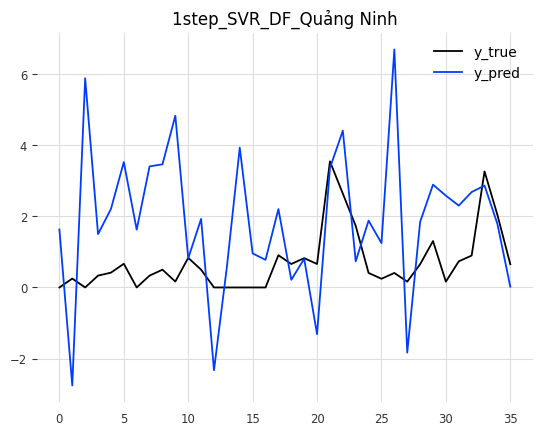

rmse,mae,mape,mse
2.3535576935511813,1.8333585616258072,2217613633123972.0,5.539233816873955
✨✨✨✨✨✨✨✨2✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨PoissonRegressor✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,max_iter,fit_intercept,alpha
0,Bình Phước,PoissonRegressor,15.990819,1,159,False,6.907746e-07
1,An Giang,PoissonRegressor,11.155777,1,125,False,1.038937e-06
2,Quảng Ninh,PoissonRegressor,2.362772,1,60,False,4.690667e-03


,Total_Evaporation,Total_Rainfall,Max_Daily_Rainfall,n_raining_days,Average_temperature,Max_Average_Temperature,Min_Average_Temperature,Max_Absolute_Temperature,Min_Absolute_Temperature,Average_Humidity,Min_Humidity,n_hours_sunshine,Dengue_fever_rates,year_month
4,0.475240,0.380768,0.331554,0.500000,0.474359,0.377049,0.472973,0.615385,0.570094,0.536585,0.650,0.836449,24.003476,2013-09-30
5,0.778270,0.670609,0.764260,0.500000,0.576923,0.704918,0.351351,0.507692,0.401869,0.365854,0.325,0.906542,13.033561,2013-10-31
6,0.652624,0.138426,0.140489,0.500000,0.474359,0.573770,0.297297,0.569231,0.383178,0.292683,0.575,0.500000,10.861301,2013-11-30
7,0.793053,0.501939,0.438325,0.500000,0.307692,0.377049,0.162162,0.476923,0.289720,0.414634,0.300,0.542056,9.666558,2013-12-31
8,0.688101,0.408879,0.463613,0.500000,0.461539,0.622951,0.243243,0.692308,0.383178,0.219512,0.275,0.771028,2.895442,2014-01-31
9,0.461936,0.499031,0.483282,0.500000,0.717949,0.885246,0.554054,0.738461,0.644860,0.634146,0.575,0.322430,1.501340,2014-02-28
10,0.852180,0.504847,0.491711,1.305556,0.794872,0.606557,0.770270,1.107692,0.775701,0.414634,0.400,0.691589,1.823056,2014-03-31
11,0.150037,0.786933,0.736162,-0.138889,0.487179,0.639344,0.635135,0.261539,0.616822,0.560976,0.950,0.336449,1.072386,2014-04-30
12,0.386548,0.510663,0.410228,0.333333,0.897436,0.540984,0.486486,0.569231,0.626168,0.512195,0.575,0.663551,2.680965,2014-05-31
13,0.660015,0.510663,0.401798,0.888889,-0.012821,0.131148,0.310811,0.353846,0.514019,0.634146,0.675,-0.028037,2.680965,2014-06-30


🐹Len(prediction): 36
mean_squared_error: 431.4805
rmse: 20.772107635996658
mape: 4.858172091994206


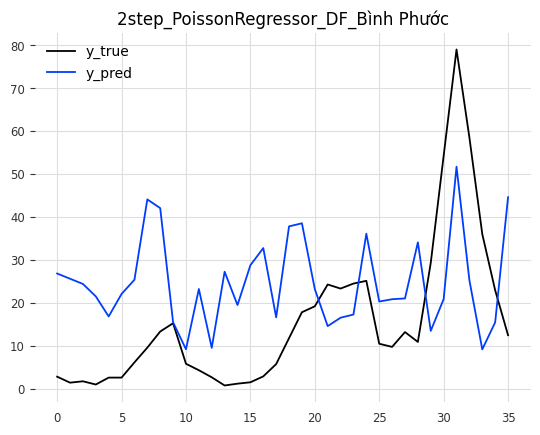

rmse,mae,mape,mse
20.772107635996658,18.415922265485612,4.858172091994206,431.4804556414307
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,max_iter,fit_intercept,alpha
0,Bình Phước,PoissonRegressor,15.990819,1,159,False,6.907746e-07
1,An Giang,PoissonRegressor,11.155777,1,125,False,1.038937e-06
2,Quảng Ninh,PoissonRegressor,2.362772,1,60,False,4.690667e-03


,Total_Evaporation,Total_Rainfall,Max_Daily_Rainfall,n_raining_days,Average_temperature,Max_Average_Temperature,Min_Average_Temperature,Max_Absolute_Temperature,Min_Absolute_Temperature,Average_Humidity,Min_Humidity,n_hours_sunshine,Dengue_fever_rates,year_month
4,0.275862,0.000000,0.493031,0.560976,0.532258,0.223881,0.493151,0.5500,0.611650,0.45,0.605263,0.440,6.501649,2013-09-30
5,0.465517,0.474796,0.475610,0.560976,0.548387,0.388060,0.479452,0.3125,0.524272,0.35,0.394737,0.830,6.315887,2013-10-31
6,0.500000,0.354905,0.244774,0.560976,0.612903,0.388060,0.534247,0.4125,0.660194,0.25,0.394737,0.650,9.706033,2013-11-30
7,0.574713,0.453678,0.523519,0.560976,0.161290,0.029851,0.150685,0.4000,0.165048,0.25,0.552632,0.610,9.055868,2013-12-31
8,0.402299,0.435286,0.275261,0.560976,0.532258,0.447761,0.136986,0.4125,0.417476,0.25,0.236842,0.625,4.545876,2014-01-31
9,0.327586,0.464578,0.423345,0.560976,0.725807,0.582090,0.890411,0.6250,0.912621,0.50,0.763158,0.590,2.180165,2014-02-28
10,0.568966,0.465259,0.427700,1.268293,0.903226,0.731343,0.808219,0.8000,0.737864,0.25,0.315790,0.670,1.994619,2014-03-31
11,0.402299,0.541553,0.567073,0.000000,0.774193,0.507463,0.739726,0.5375,0.786408,0.45,0.473684,0.375,3.942852,2014-04-30
12,0.373563,0.473433,0.554007,0.414634,0.741935,0.447761,0.698630,0.4500,0.747573,0.60,0.657895,0.585,3.989238,2014-05-31
13,0.431034,0.442779,0.253484,0.902439,0.370968,0.044776,0.452055,0.4000,0.514563,0.70,0.657895,0.120,3.571760,2014-06-30


🐹Len(prediction): 36
mean_squared_error: 203.9313
rmse: 14.280450346874284
mape: 2.2302256910026106


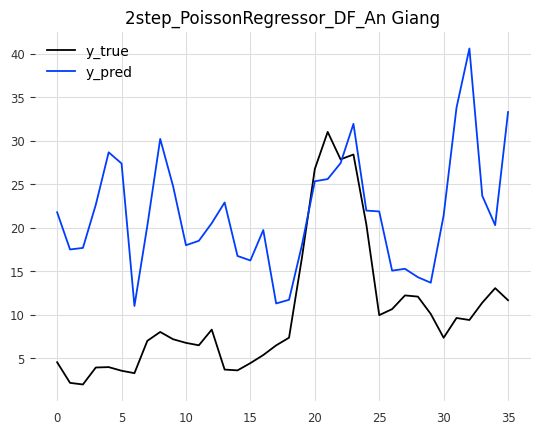

rmse,mae,mape,mse
14.280450346874284,11.905511824375685,2.2302256910026106,203.93126210954185
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,max_iter,fit_intercept,alpha
0,Bình Phước,PoissonRegressor,15.990819,1,159,False,6.907746e-07
1,An Giang,PoissonRegressor,11.155777,1,125,False,1.038937e-06
2,Quảng Ninh,PoissonRegressor,2.362772,1,60,False,4.690667e-03


,Total_Evaporation,Total_Rainfall,Max_Daily_Rainfall,n_raining_days,Average_temperature,Max_Average_Temperature,Min_Average_Temperature,Max_Absolute_Temperature,Min_Absolute_Temperature,Average_Humidity,Min_Humidity,n_hours_sunshine,Dengue_fever_rates,year_month
4,0.493954,0.486828,0.476311,0.585366,0.401891,0.375546,0.486762,0.458432,0.425497,0.349377,0.281768,0.450704,2.442105,2013-09-30
5,0.872138,0.158179,0.430626,0.585366,0.392435,0.480349,0.395112,0.522565,0.314570,0.077299,0.143646,0.680955,1.852632,2013-10-31
6,0.246977,0.653588,0.863790,0.585366,0.286052,0.211790,0.466395,0.434679,0.509934,0.491331,0.491713,0.315983,0.926316,2013-11-30
7,0.529972,0.378527,0.302030,0.585366,0.000000,0.144105,0.000000,0.118765,0.157285,0.219253,0.237569,0.794856,1.431579,2013-12-31
8,0.447132,0.477459,0.535533,0.975610,0.602837,0.561135,0.655805,0.539192,0.582781,0.562308,0.381215,0.489896,0.000000,2014-01-31
9,0.206329,0.547911,0.604907,0.939024,0.529551,0.355895,0.665988,0.676960,0.637417,0.656944,0.607735,0.161666,0.250125,2014-02-28
10,0.308721,0.560277,0.603215,0.646342,0.728132,0.668122,0.778004,0.676960,0.892384,0.692433,0.933702,0.471525,0.000000,2014-03-31
11,0.638024,0.559903,0.648900,0.768293,0.867612,0.868996,0.883910,0.714964,0.870861,0.266571,0.270718,0.597673,0.333500,2014-04-30
12,0.756367,0.465842,0.550761,0.658537,0.770686,0.768559,0.708758,0.988124,0.624172,0.171935,0.265193,1.088794,0.416875,2014-05-31
13,0.486236,0.839835,0.584602,0.097561,0.572104,0.628821,0.621181,0.555820,0.725166,0.432184,0.386740,0.478873,0.667000,2014-06-30


🐹Len(prediction): 36
mean_squared_error: 5.2409
rmse: 2.28929123144239
mape: 3182615180960207.0


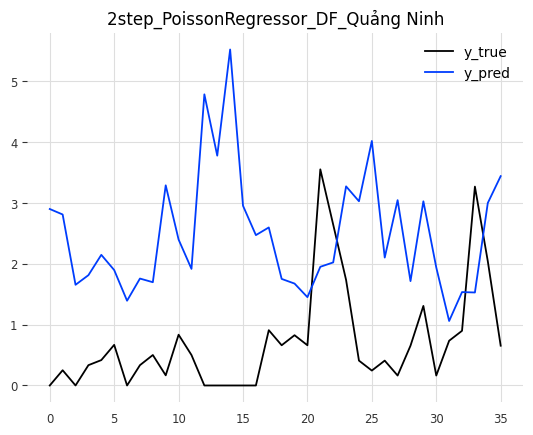

rmse,mae,mape,mse
2.28929123144239,1.9800129621191718,3182615180960207.0,5.2408543423590155
✨✨✨✨✨✨✨✨SVMRBF✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,max_iter,kernel,epsilon
0,Bình Phước,SVMRBF,15.967680,1,61,rbf,1.094056e-04
1,An Giang,SVMRBF,8.154585,1,172,rbf,1.201421e-06
2,Quảng Ninh,SVMRBF,2.104153,1,111,rbf,1.282831e-08


,Total_Evaporation,Total_Rainfall,Max_Daily_Rainfall,n_raining_days,Average_temperature,Max_Average_Temperature,Min_Average_Temperature,Max_Absolute_Temperature,Min_Absolute_Temperature,Average_Humidity,Min_Humidity,n_hours_sunshine,Dengue_fever_rates,year_month
4,0.475240,0.380768,0.331554,0.500000,0.474359,0.377049,0.472973,0.615385,0.570094,0.536585,0.650,0.836449,24.003476,2013-09-30
5,0.778270,0.670609,0.764260,0.500000,0.576923,0.704918,0.351351,0.507692,0.401869,0.365854,0.325,0.906542,13.033561,2013-10-31
6,0.652624,0.138426,0.140489,0.500000,0.474359,0.573770,0.297297,0.569231,0.383178,0.292683,0.575,0.500000,10.861301,2013-11-30
7,0.793053,0.501939,0.438325,0.500000,0.307692,0.377049,0.162162,0.476923,0.289720,0.414634,0.300,0.542056,9.666558,2013-12-31
8,0.688101,0.408879,0.463613,0.500000,0.461539,0.622951,0.243243,0.692308,0.383178,0.219512,0.275,0.771028,2.895442,2014-01-31
9,0.461936,0.499031,0.483282,0.500000,0.717949,0.885246,0.554054,0.738461,0.644860,0.634146,0.575,0.322430,1.501340,2014-02-28
10,0.852180,0.504847,0.491711,1.305556,0.794872,0.606557,0.770270,1.107692,0.775701,0.414634,0.400,0.691589,1.823056,2014-03-31
11,0.150037,0.786933,0.736162,-0.138889,0.487179,0.639344,0.635135,0.261539,0.616822,0.560976,0.950,0.336449,1.072386,2014-04-30
12,0.386548,0.510663,0.410228,0.333333,0.897436,0.540984,0.486486,0.569231,0.626168,0.512195,0.575,0.663551,2.680965,2014-05-31
13,0.660015,0.510663,0.401798,0.888889,-0.012821,0.131148,0.310811,0.353846,0.514019,0.634146,0.675,-0.028037,2.680965,2014-06-30


🐹Len(prediction): 36
mean_squared_error: 733.4147
rmse: 27.08163076325293
mape: 5.638792327577725


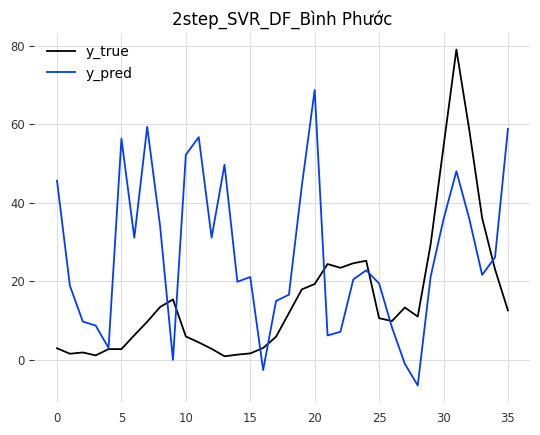

rmse,mae,mape,mse
27.08163076325293,21.580088692250158,5.638792327577725,733.4147247971677
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,max_iter,kernel,epsilon
0,Bình Phước,SVMRBF,15.967680,1,61,rbf,1.094056e-04
1,An Giang,SVMRBF,8.154585,1,172,rbf,1.201421e-06
2,Quảng Ninh,SVMRBF,2.104153,1,111,rbf,1.282831e-08


,Total_Evaporation,Total_Rainfall,Max_Daily_Rainfall,n_raining_days,Average_temperature,Max_Average_Temperature,Min_Average_Temperature,Max_Absolute_Temperature,Min_Absolute_Temperature,Average_Humidity,Min_Humidity,n_hours_sunshine,Dengue_fever_rates,year_month
4,0.275862,0.000000,0.493031,0.560976,0.532258,0.223881,0.493151,0.5500,0.611650,0.45,0.605263,0.440,6.501649,2013-09-30
5,0.465517,0.474796,0.475610,0.560976,0.548387,0.388060,0.479452,0.3125,0.524272,0.35,0.394737,0.830,6.315887,2013-10-31
6,0.500000,0.354905,0.244774,0.560976,0.612903,0.388060,0.534247,0.4125,0.660194,0.25,0.394737,0.650,9.706033,2013-11-30
7,0.574713,0.453678,0.523519,0.560976,0.161290,0.029851,0.150685,0.4000,0.165048,0.25,0.552632,0.610,9.055868,2013-12-31
8,0.402299,0.435286,0.275261,0.560976,0.532258,0.447761,0.136986,0.4125,0.417476,0.25,0.236842,0.625,4.545876,2014-01-31
9,0.327586,0.464578,0.423345,0.560976,0.725807,0.582090,0.890411,0.6250,0.912621,0.50,0.763158,0.590,2.180165,2014-02-28
10,0.568966,0.465259,0.427700,1.268293,0.903226,0.731343,0.808219,0.8000,0.737864,0.25,0.315790,0.670,1.994619,2014-03-31
11,0.402299,0.541553,0.567073,0.000000,0.774193,0.507463,0.739726,0.5375,0.786408,0.45,0.473684,0.375,3.942852,2014-04-30
12,0.373563,0.473433,0.554007,0.414634,0.741935,0.447761,0.698630,0.4500,0.747573,0.60,0.657895,0.585,3.989238,2014-05-31
13,0.431034,0.442779,0.253484,0.902439,0.370968,0.044776,0.452055,0.4000,0.514563,0.70,0.657895,0.120,3.571760,2014-06-30


🐹Len(prediction): 36
mean_squared_error: 253.2550
rmse: 15.913988514676019
mape: 2.2238630630910454


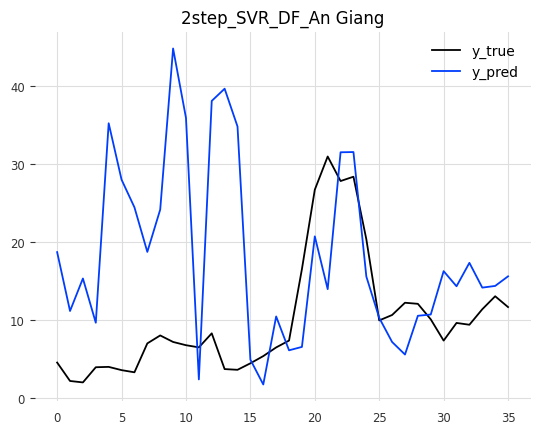

rmse,mae,mape,mse
15.913988514676019,11.42393261330752,2.2238630630910454,253.25503044524027
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,max_iter,kernel,epsilon
0,Bình Phước,SVMRBF,15.967680,1,61,rbf,1.094056e-04
1,An Giang,SVMRBF,8.154585,1,172,rbf,1.201421e-06
2,Quảng Ninh,SVMRBF,2.104153,1,111,rbf,1.282831e-08


,Total_Evaporation,Total_Rainfall,Max_Daily_Rainfall,n_raining_days,Average_temperature,Max_Average_Temperature,Min_Average_Temperature,Max_Absolute_Temperature,Min_Absolute_Temperature,Average_Humidity,Min_Humidity,n_hours_sunshine,Dengue_fever_rates,year_month
4,0.493954,0.486828,0.476311,0.585366,0.401891,0.375546,0.486762,0.458432,0.425497,0.349377,0.281768,0.450704,2.442105,2013-09-30
5,0.872138,0.158179,0.430626,0.585366,0.392435,0.480349,0.395112,0.522565,0.314570,0.077299,0.143646,0.680955,1.852632,2013-10-31
6,0.246977,0.653588,0.863790,0.585366,0.286052,0.211790,0.466395,0.434679,0.509934,0.491331,0.491713,0.315983,0.926316,2013-11-30
7,0.529972,0.378527,0.302030,0.585366,0.000000,0.144105,0.000000,0.118765,0.157285,0.219253,0.237569,0.794856,1.431579,2013-12-31
8,0.447132,0.477459,0.535533,0.975610,0.602837,0.561135,0.655805,0.539192,0.582781,0.562308,0.381215,0.489896,0.000000,2014-01-31
9,0.206329,0.547911,0.604907,0.939024,0.529551,0.355895,0.665988,0.676960,0.637417,0.656944,0.607735,0.161666,0.250125,2014-02-28
10,0.308721,0.560277,0.603215,0.646342,0.728132,0.668122,0.778004,0.676960,0.892384,0.692433,0.933702,0.471525,0.000000,2014-03-31
11,0.638024,0.559903,0.648900,0.768293,0.867612,0.868996,0.883910,0.714964,0.870861,0.266571,0.270718,0.597673,0.333500,2014-04-30
12,0.756367,0.465842,0.550761,0.658537,0.770686,0.768559,0.708758,0.988124,0.624172,0.171935,0.265193,1.088794,0.416875,2014-05-31
13,0.486236,0.839835,0.584602,0.097561,0.572104,0.628821,0.621181,0.555820,0.725166,0.432184,0.386740,0.478873,0.667000,2014-06-30


🐹Len(prediction): 36
mean_squared_error: 7.4926
rmse: 2.7372676969732175
mape: 1148497285687713.2


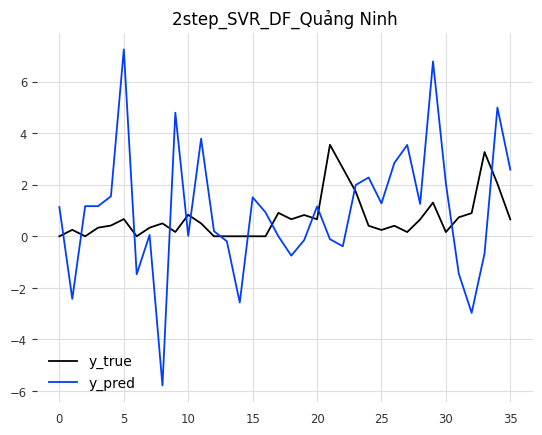

rmse,mae,mape,mse
2.7372676969732175,2.1665761170647975,1148497285687713.2,7.492634444893063
✨✨✨✨✨✨✨✨3✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨PoissonRegressor✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,max_iter,fit_intercept,alpha
0,Bình Phước,PoissonRegressor,18.853524,1,102,False,5.048328e-08
1,An Giang,PoissonRegressor,13.409207,1,143,False,8.884834e-03
2,Quảng Ninh,PoissonRegressor,2.397822,1,190,False,4.076030e-03


,Total_Evaporation,Total_Rainfall,Max_Daily_Rainfall,n_raining_days,Average_temperature,Max_Average_Temperature,Min_Average_Temperature,Max_Absolute_Temperature,Min_Absolute_Temperature,Average_Humidity,Min_Humidity,n_hours_sunshine,Dengue_fever_rates,year_month
3,0.549150,0.465103,0.553526,0.500000,0.487179,0.590164,0.364865,0.384615,0.523365,0.487805,0.475,0.014019,31.280547,2013-08-31
4,0.475240,0.380768,0.331554,0.500000,0.474359,0.377049,0.472973,0.615385,0.570094,0.536585,0.650,0.836449,24.003476,2013-09-30
5,0.778270,0.670609,0.764260,0.500000,0.576923,0.704918,0.351351,0.507692,0.401869,0.365854,0.325,0.906542,13.033561,2013-10-31
6,0.652624,0.138426,0.140489,0.500000,0.474359,0.573770,0.297297,0.569231,0.383178,0.292683,0.575,0.500000,10.861301,2013-11-30
7,0.793053,0.501939,0.438325,0.500000,0.307692,0.377049,0.162162,0.476923,0.289720,0.414634,0.300,0.542056,9.666558,2013-12-31
8,0.688101,0.408879,0.463613,0.500000,0.461539,0.622951,0.243243,0.692308,0.383178,0.219512,0.275,0.771028,2.895442,2014-01-31
9,0.461936,0.499031,0.483282,0.500000,0.717949,0.885246,0.554054,0.738461,0.644860,0.634146,0.575,0.322430,1.501340,2014-02-28
10,0.852180,0.504847,0.491711,1.305556,0.794872,0.606557,0.770270,1.107692,0.775701,0.414634,0.400,0.691589,1.823056,2014-03-31
11,0.150037,0.786933,0.736162,-0.138889,0.487179,0.639344,0.635135,0.261539,0.616822,0.560976,0.950,0.336449,1.072386,2014-04-30
12,0.386548,0.510663,0.410228,0.333333,0.897436,0.540984,0.486486,0.569231,0.626168,0.512195,0.575,0.663551,2.680965,2014-05-31


🐹Len(prediction): 36
mean_squared_error: 386.8174
rmse: 19.667673627906364
mape: 3.1780648095318274


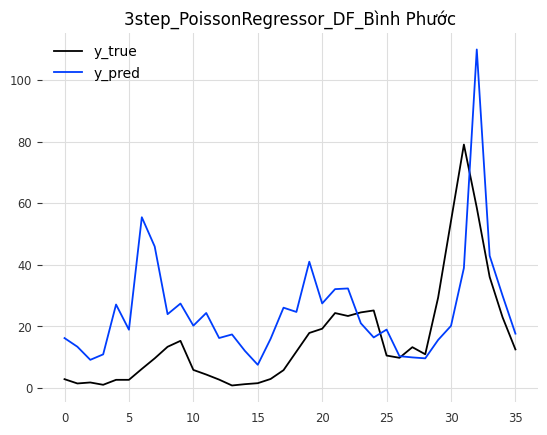

rmse,mae,mape,mse
19.667673627906364,15.30456468703351,3.1780648095318274,386.8173859338434
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,max_iter,fit_intercept,alpha
0,Bình Phước,PoissonRegressor,18.853524,1,102,False,5.048328e-08
1,An Giang,PoissonRegressor,13.409207,1,143,False,8.884834e-03
2,Quảng Ninh,PoissonRegressor,2.397822,1,190,False,4.076030e-03


,Total_Evaporation,Total_Rainfall,Max_Daily_Rainfall,n_raining_days,Average_temperature,Max_Average_Temperature,Min_Average_Temperature,Max_Absolute_Temperature,Min_Absolute_Temperature,Average_Humidity,Min_Humidity,n_hours_sunshine,Dengue_fever_rates,year_month
3,0.494253,1.000000,0.401568,0.560976,0.596774,0.447761,0.589041,0.3750,0.689320,0.35,0.578947,0.695,6.269447,2013-08-31
4,0.275862,0.000000,0.493031,0.560976,0.532258,0.223881,0.493151,0.5500,0.611650,0.45,0.605263,0.440,6.501649,2013-09-30
5,0.465517,0.474796,0.475610,0.560976,0.548387,0.388060,0.479452,0.3125,0.524272,0.35,0.394737,0.830,6.315887,2013-10-31
6,0.500000,0.354905,0.244774,0.560976,0.612903,0.388060,0.534247,0.4125,0.660194,0.25,0.394737,0.650,9.706033,2013-11-30
7,0.574713,0.453678,0.523519,0.560976,0.161290,0.029851,0.150685,0.4000,0.165048,0.25,0.552632,0.610,9.055868,2013-12-31
8,0.402299,0.435286,0.275261,0.560976,0.532258,0.447761,0.136986,0.4125,0.417476,0.25,0.236842,0.625,4.545876,2014-01-31
9,0.327586,0.464578,0.423345,0.560976,0.725807,0.582090,0.890411,0.6250,0.912621,0.50,0.763158,0.590,2.180165,2014-02-28
10,0.568966,0.465259,0.427700,1.268293,0.903226,0.731343,0.808219,0.8000,0.737864,0.25,0.315790,0.670,1.994619,2014-03-31
11,0.402299,0.541553,0.567073,0.000000,0.774193,0.507463,0.739726,0.5375,0.786408,0.45,0.473684,0.375,3.942852,2014-04-30
12,0.373563,0.473433,0.554007,0.414634,0.741935,0.447761,0.698630,0.4500,0.747573,0.60,0.657895,0.585,3.989238,2014-05-31


🐹Len(prediction): 36
mean_squared_error: 227.7332
rmse: 15.090830306167655
mape: 2.633488083479532


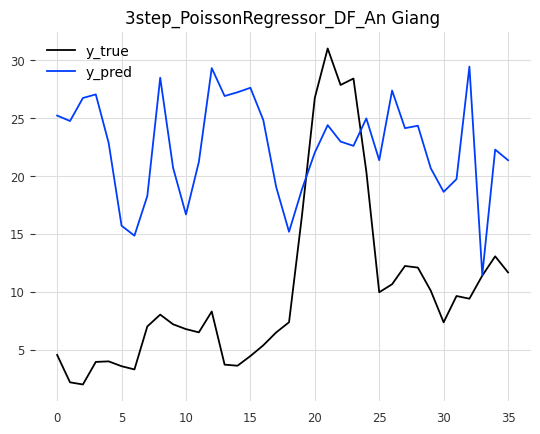

rmse,mae,mape,mse
15.090830306167655,13.506977712184135,2.633488083479532,227.73315932954816
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,max_iter,fit_intercept,alpha
0,Bình Phước,PoissonRegressor,18.853524,1,102,False,5.048328e-08
1,An Giang,PoissonRegressor,13.409207,1,143,False,8.884834e-03
2,Quảng Ninh,PoissonRegressor,2.397822,1,190,False,4.076030e-03


,Total_Evaporation,Total_Rainfall,Max_Daily_Rainfall,n_raining_days,Average_temperature,Max_Average_Temperature,Min_Average_Temperature,Max_Absolute_Temperature,Min_Absolute_Temperature,Average_Humidity,Min_Humidity,n_hours_sunshine,Dengue_fever_rates,year_month
3,0.573707,0.160052,0.607445,0.585366,0.536643,0.602620,0.558045,0.726841,0.599338,0.325718,0.226519,0.710349,0.926316,2013-08-31
4,0.493954,0.486828,0.476311,0.585366,0.401891,0.375546,0.486762,0.458432,0.425497,0.349377,0.281768,0.450704,2.442105,2013-09-30
5,0.872138,0.158179,0.430626,0.585366,0.392435,0.480349,0.395112,0.522565,0.314570,0.077299,0.143646,0.680955,1.852632,2013-10-31
6,0.246977,0.653588,0.863790,0.585366,0.286052,0.211790,0.466395,0.434679,0.509934,0.491331,0.491713,0.315983,0.926316,2013-11-30
7,0.529972,0.378527,0.302030,0.585366,0.000000,0.144105,0.000000,0.118765,0.157285,0.219253,0.237569,0.794856,1.431579,2013-12-31
8,0.447132,0.477459,0.535533,0.975610,0.602837,0.561135,0.655805,0.539192,0.582781,0.562308,0.381215,0.489896,0.000000,2014-01-31
9,0.206329,0.547911,0.604907,0.939024,0.529551,0.355895,0.665988,0.676960,0.637417,0.656944,0.607735,0.161666,0.250125,2014-02-28
10,0.308721,0.560277,0.603215,0.646342,0.728132,0.668122,0.778004,0.676960,0.892384,0.692433,0.933702,0.471525,0.000000,2014-03-31
11,0.638024,0.559903,0.648900,0.768293,0.867612,0.868996,0.883910,0.714964,0.870861,0.266571,0.270718,0.597673,0.333500,2014-04-30
12,0.756367,0.465842,0.550761,0.658537,0.770686,0.768559,0.708758,0.988124,0.624172,0.171935,0.265193,1.088794,0.416875,2014-05-31


🐹Len(prediction): 36
mean_squared_error: 6.4467
rmse: 2.539030615449851
mape: 3423681510095699.0


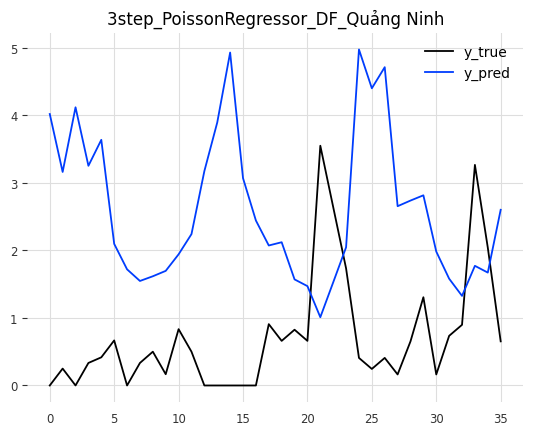

rmse,mae,mape,mse
2.539030615449851,2.186764917821908,3423681510095699.0,6.446676466191648
✨✨✨✨✨✨✨✨SVMRBF✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,max_iter,kernel,epsilon
0,Bình Phước,SVMRBF,16.665955,1,122,rbf,0.044833
1,An Giang,SVMRBF,9.047734,1,105,rbf,0.000032
2,Quảng Ninh,SVMRBF,1.573864,1,101,rbf,0.000283


,Total_Evaporation,Total_Rainfall,Max_Daily_Rainfall,n_raining_days,Average_temperature,Max_Average_Temperature,Min_Average_Temperature,Max_Absolute_Temperature,Min_Absolute_Temperature,Average_Humidity,Min_Humidity,n_hours_sunshine,Dengue_fever_rates,year_month
3,0.549150,0.465103,0.553526,0.500000,0.487179,0.590164,0.364865,0.384615,0.523365,0.487805,0.475,0.014019,31.280547,2013-08-31
4,0.475240,0.380768,0.331554,0.500000,0.474359,0.377049,0.472973,0.615385,0.570094,0.536585,0.650,0.836449,24.003476,2013-09-30
5,0.778270,0.670609,0.764260,0.500000,0.576923,0.704918,0.351351,0.507692,0.401869,0.365854,0.325,0.906542,13.033561,2013-10-31
6,0.652624,0.138426,0.140489,0.500000,0.474359,0.573770,0.297297,0.569231,0.383178,0.292683,0.575,0.500000,10.861301,2013-11-30
7,0.793053,0.501939,0.438325,0.500000,0.307692,0.377049,0.162162,0.476923,0.289720,0.414634,0.300,0.542056,9.666558,2013-12-31
8,0.688101,0.408879,0.463613,0.500000,0.461539,0.622951,0.243243,0.692308,0.383178,0.219512,0.275,0.771028,2.895442,2014-01-31
9,0.461936,0.499031,0.483282,0.500000,0.717949,0.885246,0.554054,0.738461,0.644860,0.634146,0.575,0.322430,1.501340,2014-02-28
10,0.852180,0.504847,0.491711,1.305556,0.794872,0.606557,0.770270,1.107692,0.775701,0.414634,0.400,0.691589,1.823056,2014-03-31
11,0.150037,0.786933,0.736162,-0.138889,0.487179,0.639344,0.635135,0.261539,0.616822,0.560976,0.950,0.336449,1.072386,2014-04-30
12,0.386548,0.510663,0.410228,0.333333,0.897436,0.540984,0.486486,0.569231,0.626168,0.512195,0.575,0.663551,2.680965,2014-05-31


🐹Len(prediction): 36
mean_squared_error: 760.8778
rmse: 27.584013863070243
mape: 2.7274591021888064


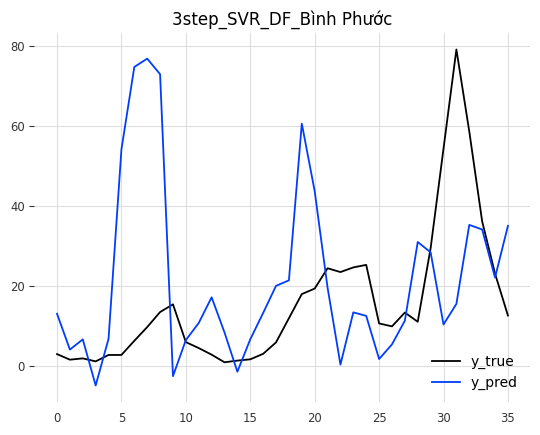

rmse,mae,mape,mse
27.584013863070243,18.714357208095656,2.7274591021888064,760.8778207980514
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,max_iter,kernel,epsilon
0,Bình Phước,SVMRBF,16.665955,1,122,rbf,0.044833
1,An Giang,SVMRBF,9.047734,1,105,rbf,0.000032
2,Quảng Ninh,SVMRBF,1.573864,1,101,rbf,0.000283


,Total_Evaporation,Total_Rainfall,Max_Daily_Rainfall,n_raining_days,Average_temperature,Max_Average_Temperature,Min_Average_Temperature,Max_Absolute_Temperature,Min_Absolute_Temperature,Average_Humidity,Min_Humidity,n_hours_sunshine,Dengue_fever_rates,year_month
3,0.494253,1.000000,0.401568,0.560976,0.596774,0.447761,0.589041,0.3750,0.689320,0.35,0.578947,0.695,6.269447,2013-08-31
4,0.275862,0.000000,0.493031,0.560976,0.532258,0.223881,0.493151,0.5500,0.611650,0.45,0.605263,0.440,6.501649,2013-09-30
5,0.465517,0.474796,0.475610,0.560976,0.548387,0.388060,0.479452,0.3125,0.524272,0.35,0.394737,0.830,6.315887,2013-10-31
6,0.500000,0.354905,0.244774,0.560976,0.612903,0.388060,0.534247,0.4125,0.660194,0.25,0.394737,0.650,9.706033,2013-11-30
7,0.574713,0.453678,0.523519,0.560976,0.161290,0.029851,0.150685,0.4000,0.165048,0.25,0.552632,0.610,9.055868,2013-12-31
8,0.402299,0.435286,0.275261,0.560976,0.532258,0.447761,0.136986,0.4125,0.417476,0.25,0.236842,0.625,4.545876,2014-01-31
9,0.327586,0.464578,0.423345,0.560976,0.725807,0.582090,0.890411,0.6250,0.912621,0.50,0.763158,0.590,2.180165,2014-02-28
10,0.568966,0.465259,0.427700,1.268293,0.903226,0.731343,0.808219,0.8000,0.737864,0.25,0.315790,0.670,1.994619,2014-03-31
11,0.402299,0.541553,0.567073,0.000000,0.774193,0.507463,0.739726,0.5375,0.786408,0.45,0.473684,0.375,3.942852,2014-04-30
12,0.373563,0.473433,0.554007,0.414634,0.741935,0.447761,0.698630,0.4500,0.747573,0.60,0.657895,0.585,3.989238,2014-05-31


🐹Len(prediction): 36
mean_squared_error: 239.8694
rmse: 15.487717300587393
mape: 2.1614533628266908


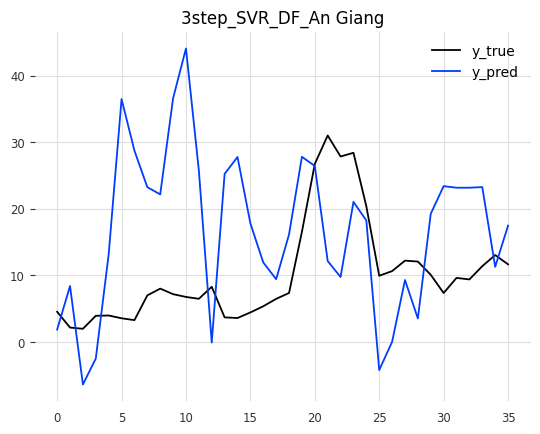

rmse,mae,mape,mse
15.487717300587393,12.758788468018574,2.1614533628266908,239.86938718291407
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,max_iter,kernel,epsilon
0,Bình Phước,SVMRBF,16.665955,1,122,rbf,0.044833
1,An Giang,SVMRBF,9.047734,1,105,rbf,0.000032
2,Quảng Ninh,SVMRBF,1.573864,1,101,rbf,0.000283


,Total_Evaporation,Total_Rainfall,Max_Daily_Rainfall,n_raining_days,Average_temperature,Max_Average_Temperature,Min_Average_Temperature,Max_Absolute_Temperature,Min_Absolute_Temperature,Average_Humidity,Min_Humidity,n_hours_sunshine,Dengue_fever_rates,year_month
3,0.573707,0.160052,0.607445,0.585366,0.536643,0.602620,0.558045,0.726841,0.599338,0.325718,0.226519,0.710349,0.926316,2013-08-31
4,0.493954,0.486828,0.476311,0.585366,0.401891,0.375546,0.486762,0.458432,0.425497,0.349377,0.281768,0.450704,2.442105,2013-09-30
5,0.872138,0.158179,0.430626,0.585366,0.392435,0.480349,0.395112,0.522565,0.314570,0.077299,0.143646,0.680955,1.852632,2013-10-31
6,0.246977,0.653588,0.863790,0.585366,0.286052,0.211790,0.466395,0.434679,0.509934,0.491331,0.491713,0.315983,0.926316,2013-11-30
7,0.529972,0.378527,0.302030,0.585366,0.000000,0.144105,0.000000,0.118765,0.157285,0.219253,0.237569,0.794856,1.431579,2013-12-31
8,0.447132,0.477459,0.535533,0.975610,0.602837,0.561135,0.655805,0.539192,0.582781,0.562308,0.381215,0.489896,0.000000,2014-01-31
9,0.206329,0.547911,0.604907,0.939024,0.529551,0.355895,0.665988,0.676960,0.637417,0.656944,0.607735,0.161666,0.250125,2014-02-28
10,0.308721,0.560277,0.603215,0.646342,0.728132,0.668122,0.778004,0.676960,0.892384,0.692433,0.933702,0.471525,0.000000,2014-03-31
11,0.638024,0.559903,0.648900,0.768293,0.867612,0.868996,0.883910,0.714964,0.870861,0.266571,0.270718,0.597673,0.333500,2014-04-30
12,0.756367,0.465842,0.550761,0.658537,0.770686,0.768559,0.708758,0.988124,0.624172,0.171935,0.265193,1.088794,0.416875,2014-05-31


🐹Len(prediction): 36
mean_squared_error: 8.7331
rmse: 2.955178968785477
mape: 2172691976664779.5


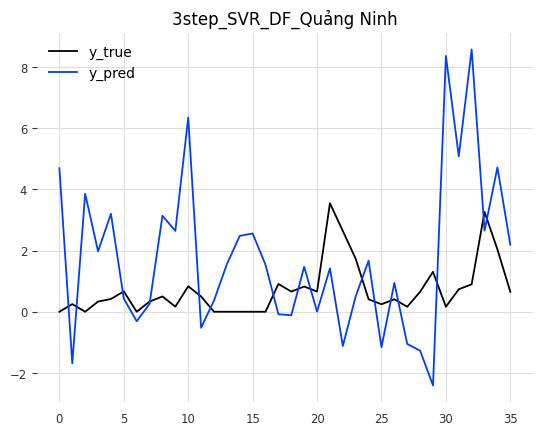

rmse,mae,mape,mse
2.955178968785477,2.25106674549808,2172691976664779.5,8.733082737551994
✨✨✨✨✨✨✨✨4✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨PoissonRegressor✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,max_iter,fit_intercept,alpha
0,Bình Phước,PoissonRegressor,58.043382,1,152,False,0.515557
1,An Giang,PoissonRegressor,12.526537,1,66,False,0.000023
2,Quảng Ninh,PoissonRegressor,1.981571,1,153,False,0.000071


,Total_Evaporation,Total_Rainfall,Max_Daily_Rainfall,n_raining_days,Average_temperature,Max_Average_Temperature,Min_Average_Temperature,Max_Absolute_Temperature,Min_Absolute_Temperature,Average_Humidity,Min_Humidity,n_hours_sunshine,Dengue_fever_rates,year_month
2,0.630451,0.661884,0.508570,0.500000,0.448718,0.409836,0.324324,0.569231,0.448598,0.487805,0.475,0.457944,42.250462,2013-07-31
3,0.549150,0.465103,0.553526,0.500000,0.487179,0.590164,0.364865,0.384615,0.523365,0.487805,0.475,0.014019,31.280547,2013-08-31
4,0.475240,0.380768,0.331554,0.500000,0.474359,0.377049,0.472973,0.615385,0.570094,0.536585,0.650,0.836449,24.003476,2013-09-30
5,0.778270,0.670609,0.764260,0.500000,0.576923,0.704918,0.351351,0.507692,0.401869,0.365854,0.325,0.906542,13.033561,2013-10-31
6,0.652624,0.138426,0.140489,0.500000,0.474359,0.573770,0.297297,0.569231,0.383178,0.292683,0.575,0.500000,10.861301,2013-11-30
7,0.793053,0.501939,0.438325,0.500000,0.307692,0.377049,0.162162,0.476923,0.289720,0.414634,0.300,0.542056,9.666558,2013-12-31
8,0.688101,0.408879,0.463613,0.500000,0.461539,0.622951,0.243243,0.692308,0.383178,0.219512,0.275,0.771028,2.895442,2014-01-31
9,0.461936,0.499031,0.483282,0.500000,0.717949,0.885246,0.554054,0.738461,0.644860,0.634146,0.575,0.322430,1.501340,2014-02-28
10,0.852180,0.504847,0.491711,1.305556,0.794872,0.606557,0.770270,1.107692,0.775701,0.414634,0.400,0.691589,1.823056,2014-03-31
11,0.150037,0.786933,0.736162,-0.138889,0.487179,0.639344,0.635135,0.261539,0.616822,0.560976,0.950,0.336449,1.072386,2014-04-30


🐹Len(prediction): 36
mean_squared_error: 5174.1491
rmse: 71.93155865343684
mape: 20.00074619469228


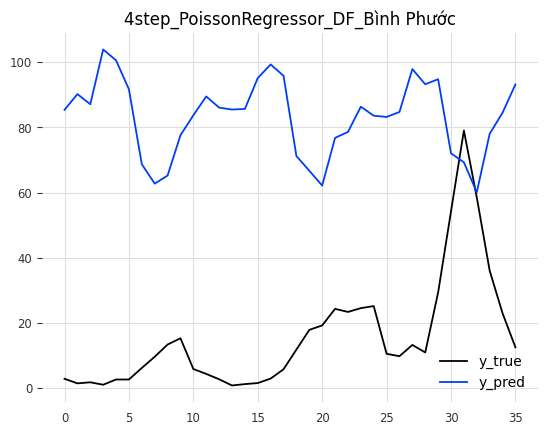

rmse,mae,mape,mse
71.93155865343684,67.85492850442563,20.00074619469228,5174.149130312825
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,max_iter,fit_intercept,alpha
0,Bình Phước,PoissonRegressor,58.043382,1,152,False,0.515557
1,An Giang,PoissonRegressor,12.526537,1,66,False,0.000023
2,Quảng Ninh,PoissonRegressor,1.981571,1,153,False,0.000071


,Total_Evaporation,Total_Rainfall,Max_Daily_Rainfall,n_raining_days,Average_temperature,Max_Average_Temperature,Min_Average_Temperature,Max_Absolute_Temperature,Min_Absolute_Temperature,Average_Humidity,Min_Humidity,n_hours_sunshine,Dengue_fever_rates,year_month
2,0.511494,0.465940,0.414634,0.560976,0.467742,0.238806,0.438356,0.4000,0.553398,0.45,0.526316,0.390,5.387080,2013-07-31
3,0.494253,1.000000,0.401568,0.560976,0.596774,0.447761,0.589041,0.3750,0.689320,0.35,0.578947,0.695,6.269447,2013-08-31
4,0.275862,0.000000,0.493031,0.560976,0.532258,0.223881,0.493151,0.5500,0.611650,0.45,0.605263,0.440,6.501649,2013-09-30
5,0.465517,0.474796,0.475610,0.560976,0.548387,0.388060,0.479452,0.3125,0.524272,0.35,0.394737,0.830,6.315887,2013-10-31
6,0.500000,0.354905,0.244774,0.560976,0.612903,0.388060,0.534247,0.4125,0.660194,0.25,0.394737,0.650,9.706033,2013-11-30
7,0.574713,0.453678,0.523519,0.560976,0.161290,0.029851,0.150685,0.4000,0.165048,0.25,0.552632,0.610,9.055868,2013-12-31
8,0.402299,0.435286,0.275261,0.560976,0.532258,0.447761,0.136986,0.4125,0.417476,0.25,0.236842,0.625,4.545876,2014-01-31
9,0.327586,0.464578,0.423345,0.560976,0.725807,0.582090,0.890411,0.6250,0.912621,0.50,0.763158,0.590,2.180165,2014-02-28
10,0.568966,0.465259,0.427700,1.268293,0.903226,0.731343,0.808219,0.8000,0.737864,0.25,0.315790,0.670,1.994619,2014-03-31
11,0.402299,0.541553,0.567073,0.000000,0.774193,0.507463,0.739726,0.5375,0.786408,0.45,0.473684,0.375,3.942852,2014-04-30


🐹Len(prediction): 36
mean_squared_error: 225.8965
rmse: 15.029852113630186
mape: 2.5450079218176525


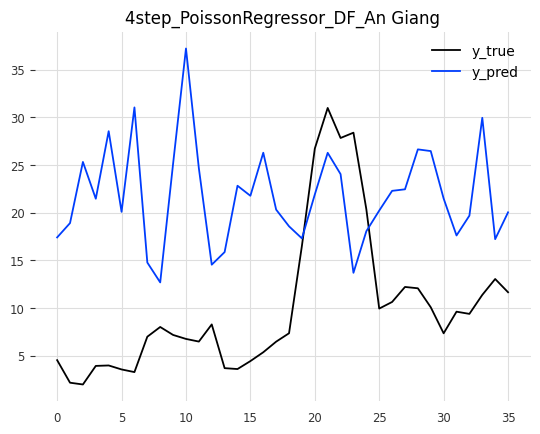

rmse,mae,mape,mse
15.029852113630186,13.253846207442962,2.5450079218176525,225.89645455759376
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,max_iter,fit_intercept,alpha
0,Bình Phước,PoissonRegressor,58.043382,1,152,False,0.515557
1,An Giang,PoissonRegressor,12.526537,1,66,False,0.000023
2,Quảng Ninh,PoissonRegressor,1.981571,1,153,False,0.000071


,Total_Evaporation,Total_Rainfall,Max_Daily_Rainfall,n_raining_days,Average_temperature,Max_Average_Temperature,Min_Average_Temperature,Max_Absolute_Temperature,Min_Absolute_Temperature,Average_Humidity,Min_Humidity,n_hours_sunshine,Dengue_fever_rates,year_month
2,0.308721,0.860821,0.576988,0.585366,0.468085,0.419214,0.547862,0.422803,0.698676,0.609626,0.834254,0.387018,0.842105,2013-07-31
3,0.573707,0.160052,0.607445,0.585366,0.536643,0.602620,0.558045,0.726841,0.599338,0.325718,0.226519,0.710349,0.926316,2013-08-31
4,0.493954,0.486828,0.476311,0.585366,0.401891,0.375546,0.486762,0.458432,0.425497,0.349377,0.281768,0.450704,2.442105,2013-09-30
5,0.872138,0.158179,0.430626,0.585366,0.392435,0.480349,0.395112,0.522565,0.314570,0.077299,0.143646,0.680955,1.852632,2013-10-31
6,0.246977,0.653588,0.863790,0.585366,0.286052,0.211790,0.466395,0.434679,0.509934,0.491331,0.491713,0.315983,0.926316,2013-11-30
7,0.529972,0.378527,0.302030,0.585366,0.000000,0.144105,0.000000,0.118765,0.157285,0.219253,0.237569,0.794856,1.431579,2013-12-31
8,0.447132,0.477459,0.535533,0.975610,0.602837,0.561135,0.655805,0.539192,0.582781,0.562308,0.381215,0.489896,0.000000,2014-01-31
9,0.206329,0.547911,0.604907,0.939024,0.529551,0.355895,0.665988,0.676960,0.637417,0.656944,0.607735,0.161666,0.250125,2014-02-28
10,0.308721,0.560277,0.603215,0.646342,0.728132,0.668122,0.778004,0.676960,0.892384,0.692433,0.933702,0.471525,0.000000,2014-03-31
11,0.638024,0.559903,0.648900,0.768293,0.867612,0.868996,0.883910,0.714964,0.870861,0.266571,0.270718,0.597673,0.333500,2014-04-30


🐹Len(prediction): 36
mean_squared_error: 4.1814
rmse: 2.0448407537306816
mape: 2265013427550183.5


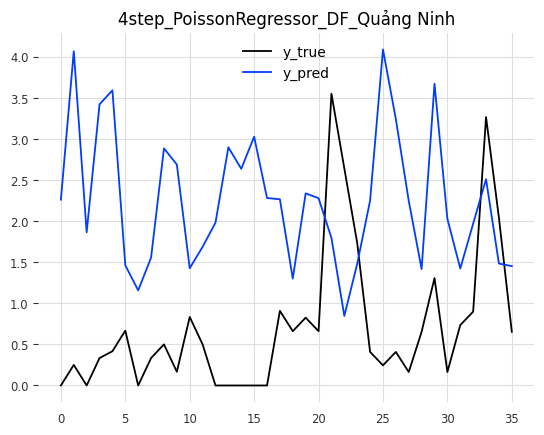

rmse,mae,mape,mse
2.0448407537306816,1.8135258886878833,2265013427550183.5,4.181373708117862
✨✨✨✨✨✨✨✨SVMRBF✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,max_iter,kernel,epsilon
0,Bình Phước,SVMRBF,22.496616,1,65,rbf,0.000697
1,An Giang,SVMRBF,10.108980,1,128,rbf,0.000035
2,Quảng Ninh,SVMRBF,1.879699,1,151,rbf,0.023143


,Total_Evaporation,Total_Rainfall,Max_Daily_Rainfall,n_raining_days,Average_temperature,Max_Average_Temperature,Min_Average_Temperature,Max_Absolute_Temperature,Min_Absolute_Temperature,Average_Humidity,Min_Humidity,n_hours_sunshine,Dengue_fever_rates,year_month
2,0.630451,0.661884,0.508570,0.500000,0.448718,0.409836,0.324324,0.569231,0.448598,0.487805,0.475,0.457944,42.250462,2013-07-31
3,0.549150,0.465103,0.553526,0.500000,0.487179,0.590164,0.364865,0.384615,0.523365,0.487805,0.475,0.014019,31.280547,2013-08-31
4,0.475240,0.380768,0.331554,0.500000,0.474359,0.377049,0.472973,0.615385,0.570094,0.536585,0.650,0.836449,24.003476,2013-09-30
5,0.778270,0.670609,0.764260,0.500000,0.576923,0.704918,0.351351,0.507692,0.401869,0.365854,0.325,0.906542,13.033561,2013-10-31
6,0.652624,0.138426,0.140489,0.500000,0.474359,0.573770,0.297297,0.569231,0.383178,0.292683,0.575,0.500000,10.861301,2013-11-30
7,0.793053,0.501939,0.438325,0.500000,0.307692,0.377049,0.162162,0.476923,0.289720,0.414634,0.300,0.542056,9.666558,2013-12-31
8,0.688101,0.408879,0.463613,0.500000,0.461539,0.622951,0.243243,0.692308,0.383178,0.219512,0.275,0.771028,2.895442,2014-01-31
9,0.461936,0.499031,0.483282,0.500000,0.717949,0.885246,0.554054,0.738461,0.644860,0.634146,0.575,0.322430,1.501340,2014-02-28
10,0.852180,0.504847,0.491711,1.305556,0.794872,0.606557,0.770270,1.107692,0.775701,0.414634,0.400,0.691589,1.823056,2014-03-31
11,0.150037,0.786933,0.736162,-0.138889,0.487179,0.639344,0.635135,0.261539,0.616822,0.560976,0.950,0.336449,1.072386,2014-04-30


🐹Len(prediction): 36
mean_squared_error: 500.4330
rmse: 22.37036032190185
mape: 2.317572820226847


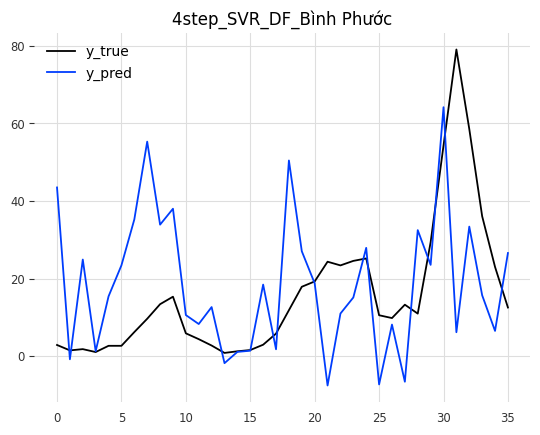

rmse,mae,mape,mse
22.37036032190185,16.355216280852858,2.317572820226847,500.43302093172065
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,max_iter,kernel,epsilon
0,Bình Phước,SVMRBF,22.496616,1,65,rbf,0.000697
1,An Giang,SVMRBF,10.108980,1,128,rbf,0.000035
2,Quảng Ninh,SVMRBF,1.879699,1,151,rbf,0.023143


,Total_Evaporation,Total_Rainfall,Max_Daily_Rainfall,n_raining_days,Average_temperature,Max_Average_Temperature,Min_Average_Temperature,Max_Absolute_Temperature,Min_Absolute_Temperature,Average_Humidity,Min_Humidity,n_hours_sunshine,Dengue_fever_rates,year_month
2,0.511494,0.465940,0.414634,0.560976,0.467742,0.238806,0.438356,0.4000,0.553398,0.45,0.526316,0.390,5.387080,2013-07-31
3,0.494253,1.000000,0.401568,0.560976,0.596774,0.447761,0.589041,0.3750,0.689320,0.35,0.578947,0.695,6.269447,2013-08-31
4,0.275862,0.000000,0.493031,0.560976,0.532258,0.223881,0.493151,0.5500,0.611650,0.45,0.605263,0.440,6.501649,2013-09-30
5,0.465517,0.474796,0.475610,0.560976,0.548387,0.388060,0.479452,0.3125,0.524272,0.35,0.394737,0.830,6.315887,2013-10-31
6,0.500000,0.354905,0.244774,0.560976,0.612903,0.388060,0.534247,0.4125,0.660194,0.25,0.394737,0.650,9.706033,2013-11-30
7,0.574713,0.453678,0.523519,0.560976,0.161290,0.029851,0.150685,0.4000,0.165048,0.25,0.552632,0.610,9.055868,2013-12-31
8,0.402299,0.435286,0.275261,0.560976,0.532258,0.447761,0.136986,0.4125,0.417476,0.25,0.236842,0.625,4.545876,2014-01-31
9,0.327586,0.464578,0.423345,0.560976,0.725807,0.582090,0.890411,0.6250,0.912621,0.50,0.763158,0.590,2.180165,2014-02-28
10,0.568966,0.465259,0.427700,1.268293,0.903226,0.731343,0.808219,0.8000,0.737864,0.25,0.315790,0.670,1.994619,2014-03-31
11,0.402299,0.541553,0.567073,0.000000,0.774193,0.507463,0.739726,0.5375,0.786408,0.45,0.473684,0.375,3.942852,2014-04-30


🐹Len(prediction): 36
mean_squared_error: 236.3624
rmse: 15.374082430807162
mape: 1.6937833720578093


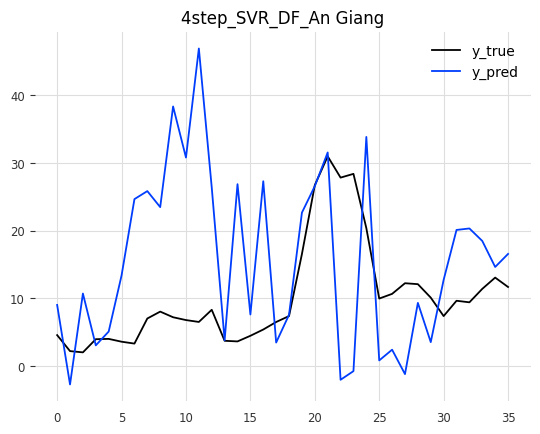

rmse,mae,mape,mse
15.374082430807162,11.415204693462147,1.6937833720578093,236.36241058925347
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,max_iter,kernel,epsilon
0,Bình Phước,SVMRBF,22.496616,1,65,rbf,0.000697
1,An Giang,SVMRBF,10.108980,1,128,rbf,0.000035
2,Quảng Ninh,SVMRBF,1.879699,1,151,rbf,0.023143


,Total_Evaporation,Total_Rainfall,Max_Daily_Rainfall,n_raining_days,Average_temperature,Max_Average_Temperature,Min_Average_Temperature,Max_Absolute_Temperature,Min_Absolute_Temperature,Average_Humidity,Min_Humidity,n_hours_sunshine,Dengue_fever_rates,year_month
2,0.308721,0.860821,0.576988,0.585366,0.468085,0.419214,0.547862,0.422803,0.698676,0.609626,0.834254,0.387018,0.842105,2013-07-31
3,0.573707,0.160052,0.607445,0.585366,0.536643,0.602620,0.558045,0.726841,0.599338,0.325718,0.226519,0.710349,0.926316,2013-08-31
4,0.493954,0.486828,0.476311,0.585366,0.401891,0.375546,0.486762,0.458432,0.425497,0.349377,0.281768,0.450704,2.442105,2013-09-30
5,0.872138,0.158179,0.430626,0.585366,0.392435,0.480349,0.395112,0.522565,0.314570,0.077299,0.143646,0.680955,1.852632,2013-10-31
6,0.246977,0.653588,0.863790,0.585366,0.286052,0.211790,0.466395,0.434679,0.509934,0.491331,0.491713,0.315983,0.926316,2013-11-30
7,0.529972,0.378527,0.302030,0.585366,0.000000,0.144105,0.000000,0.118765,0.157285,0.219253,0.237569,0.794856,1.431579,2013-12-31
8,0.447132,0.477459,0.535533,0.975610,0.602837,0.561135,0.655805,0.539192,0.582781,0.562308,0.381215,0.489896,0.000000,2014-01-31
9,0.206329,0.547911,0.604907,0.939024,0.529551,0.355895,0.665988,0.676960,0.637417,0.656944,0.607735,0.161666,0.250125,2014-02-28
10,0.308721,0.560277,0.603215,0.646342,0.728132,0.668122,0.778004,0.676960,0.892384,0.692433,0.933702,0.471525,0.000000,2014-03-31
11,0.638024,0.559903,0.648900,0.768293,0.867612,0.868996,0.883910,0.714964,0.870861,0.266571,0.270718,0.597673,0.333500,2014-04-30


🐹Len(prediction): 36
mean_squared_error: 8.9117
rmse: 2.985242492157917
mape: 2844557485791154.5


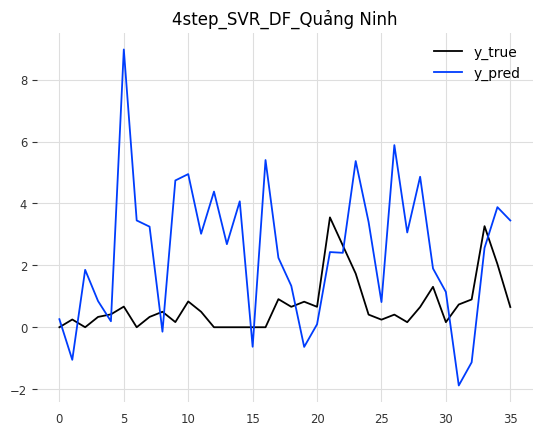

rmse,mae,mape,mse
2.985242492157917,2.3498056247038317,2844557485791154.5,8.911672736985212
✨✨✨✨✨✨✨✨5✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨PoissonRegressor✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,max_iter,fit_intercept,alpha
0,Bình Phước,PoissonRegressor,26.946178,1,117,False,7.425973e-02
1,An Giang,PoissonRegressor,10.442465,1,144,False,2.400940e-08
2,Quảng Ninh,PoissonRegressor,19.744073,1,134,False,1.167403e+00


,Total_Evaporation,Total_Rainfall,Max_Daily_Rainfall,n_raining_days,Average_temperature,Max_Average_Temperature,Min_Average_Temperature,Max_Absolute_Temperature,Min_Absolute_Temperature,Average_Humidity,Min_Humidity,n_hours_sunshine,Dengue_fever_rates,year_month
1,0.719143,0.475766,0.491711,0.500000,0.397436,0.360656,0.432432,0.461539,0.532710,0.536585,0.700,0.112149,29.977191,2013-06-30
2,0.630451,0.661884,0.508570,0.500000,0.448718,0.409836,0.324324,0.569231,0.448598,0.487805,0.475,0.457944,42.250462,2013-07-31
3,0.549150,0.465103,0.553526,0.500000,0.487179,0.590164,0.364865,0.384615,0.523365,0.487805,0.475,0.014019,31.280547,2013-08-31
4,0.475240,0.380768,0.331554,0.500000,0.474359,0.377049,0.472973,0.615385,0.570094,0.536585,0.650,0.836449,24.003476,2013-09-30
5,0.778270,0.670609,0.764260,0.500000,0.576923,0.704918,0.351351,0.507692,0.401869,0.365854,0.325,0.906542,13.033561,2013-10-31
6,0.652624,0.138426,0.140489,0.500000,0.474359,0.573770,0.297297,0.569231,0.383178,0.292683,0.575,0.500000,10.861301,2013-11-30
7,0.793053,0.501939,0.438325,0.500000,0.307692,0.377049,0.162162,0.476923,0.289720,0.414634,0.300,0.542056,9.666558,2013-12-31
8,0.688101,0.408879,0.463613,0.500000,0.461539,0.622951,0.243243,0.692308,0.383178,0.219512,0.275,0.771028,2.895442,2014-01-31
9,0.461936,0.499031,0.483282,0.500000,0.717949,0.885246,0.554054,0.738461,0.644860,0.634146,0.575,0.322430,1.501340,2014-02-28
10,0.852180,0.504847,0.491711,1.305556,0.794872,0.606557,0.770270,1.107692,0.775701,0.414634,0.400,0.691589,1.823056,2014-03-31


🐹Len(prediction): 36
mean_squared_error: 981.0434
rmse: 31.3216121587497
mape: 8.774283404740963


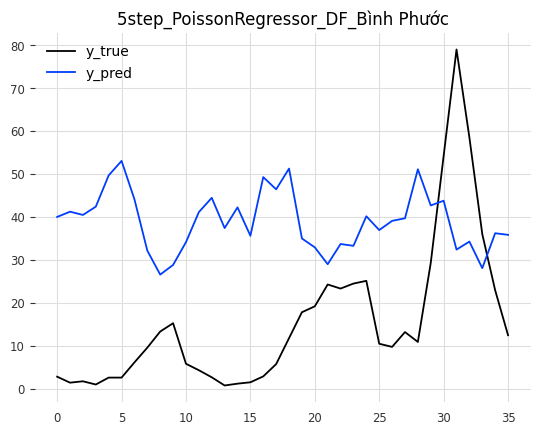

rmse,mae,mape,mse
31.3216121587497,28.290842267498544,8.774283404740963,981.0433882231371
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,max_iter,fit_intercept,alpha
0,Bình Phước,PoissonRegressor,26.946178,1,117,False,7.425973e-02
1,An Giang,PoissonRegressor,10.442465,1,144,False,2.400940e-08
2,Quảng Ninh,PoissonRegressor,19.744073,1,134,False,1.167403e+00


,Total_Evaporation,Total_Rainfall,Max_Daily_Rainfall,n_raining_days,Average_temperature,Max_Average_Temperature,Min_Average_Temperature,Max_Absolute_Temperature,Min_Absolute_Temperature,Average_Humidity,Min_Humidity,n_hours_sunshine,Dengue_fever_rates,year_month
1,0.511494,0.435286,0.344948,0.560976,0.403226,0.104478,0.479452,0.3750,0.582524,0.55,0.684211,0.320,4.040310,2013-06-30
2,0.511494,0.465940,0.414634,0.560976,0.467742,0.238806,0.438356,0.4000,0.553398,0.45,0.526316,0.390,5.387080,2013-07-31
3,0.494253,1.000000,0.401568,0.560976,0.596774,0.447761,0.589041,0.3750,0.689320,0.35,0.578947,0.695,6.269447,2013-08-31
4,0.275862,0.000000,0.493031,0.560976,0.532258,0.223881,0.493151,0.5500,0.611650,0.45,0.605263,0.440,6.501649,2013-09-30
5,0.465517,0.474796,0.475610,0.560976,0.548387,0.388060,0.479452,0.3125,0.524272,0.35,0.394737,0.830,6.315887,2013-10-31
6,0.500000,0.354905,0.244774,0.560976,0.612903,0.388060,0.534247,0.4125,0.660194,0.25,0.394737,0.650,9.706033,2013-11-30
7,0.574713,0.453678,0.523519,0.560976,0.161290,0.029851,0.150685,0.4000,0.165048,0.25,0.552632,0.610,9.055868,2013-12-31
8,0.402299,0.435286,0.275261,0.560976,0.532258,0.447761,0.136986,0.4125,0.417476,0.25,0.236842,0.625,4.545876,2014-01-31
9,0.327586,0.464578,0.423345,0.560976,0.725807,0.582090,0.890411,0.6250,0.912621,0.50,0.763158,0.590,2.180165,2014-02-28
10,0.568966,0.465259,0.427700,1.268293,0.903226,0.731343,0.808219,0.8000,0.737864,0.25,0.315790,0.670,1.994619,2014-03-31


🐹Len(prediction): 36
mean_squared_error: 176.8794
rmse: 13.299600179802106
mape: 1.8925188723386275


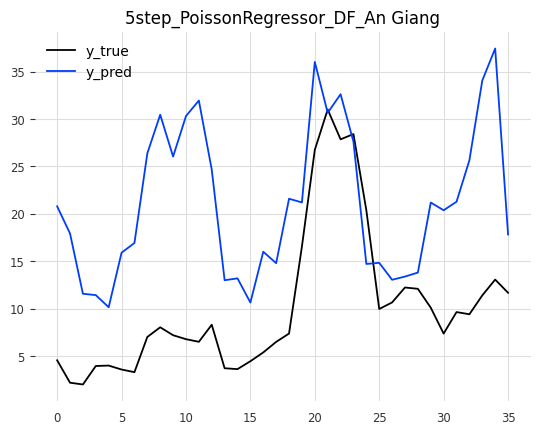

rmse,mae,mape,mse
13.299600179802106,11.278060466448434,1.8925188723386275,176.87936494259222
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,max_iter,fit_intercept,alpha
0,Bình Phước,PoissonRegressor,26.946178,1,117,False,7.425973e-02
1,An Giang,PoissonRegressor,10.442465,1,144,False,2.400940e-08
2,Quảng Ninh,PoissonRegressor,19.744073,1,134,False,1.167403e+00


,Total_Evaporation,Total_Rainfall,Max_Daily_Rainfall,n_raining_days,Average_temperature,Max_Average_Temperature,Min_Average_Temperature,Max_Absolute_Temperature,Min_Absolute_Temperature,Average_Humidity,Min_Humidity,n_hours_sunshine,Dengue_fever_rates,year_month
1,0.643169,0.500318,0.551607,0.585366,0.579196,0.554585,0.613035,0.536817,0.531457,0.242912,0.121547,0.639314,0.842105,2013-06-30
2,0.308721,0.860821,0.576988,0.585366,0.468085,0.419214,0.547862,0.422803,0.698676,0.609626,0.834254,0.387018,0.842105,2013-07-31
3,0.573707,0.160052,0.607445,0.585366,0.536643,0.602620,0.558045,0.726841,0.599338,0.325718,0.226519,0.710349,0.926316,2013-08-31
4,0.493954,0.486828,0.476311,0.585366,0.401891,0.375546,0.486762,0.458432,0.425497,0.349377,0.281768,0.450704,2.442105,2013-09-30
5,0.872138,0.158179,0.430626,0.585366,0.392435,0.480349,0.395112,0.522565,0.314570,0.077299,0.143646,0.680955,1.852632,2013-10-31
6,0.246977,0.653588,0.863790,0.585366,0.286052,0.211790,0.466395,0.434679,0.509934,0.491331,0.491713,0.315983,0.926316,2013-11-30
7,0.529972,0.378527,0.302030,0.585366,0.000000,0.144105,0.000000,0.118765,0.157285,0.219253,0.237569,0.794856,1.431579,2013-12-31
8,0.447132,0.477459,0.535533,0.975610,0.602837,0.561135,0.655805,0.539192,0.582781,0.562308,0.381215,0.489896,0.000000,2014-01-31
9,0.206329,0.547911,0.604907,0.939024,0.529551,0.355895,0.665988,0.676960,0.637417,0.656944,0.607735,0.161666,0.250125,2014-02-28
10,0.308721,0.560277,0.603215,0.646342,0.728132,0.668122,0.778004,0.676960,0.892384,0.692433,0.933702,0.471525,0.000000,2014-03-31


🐹Len(prediction): 36
mean_squared_error: 387.9786
rmse: 19.697171215187137
mape: 2.0541760108545172e+16


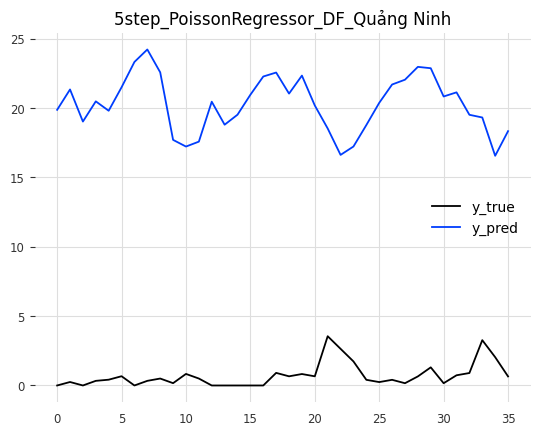

rmse,mae,mape,mse
19.697171215187137,19.542695522807954,2.0541760108545172e+16,387.97855388039676
✨✨✨✨✨✨✨✨SVMRBF✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,max_iter,kernel,epsilon
0,Bình Phước,SVMRBF,21.186220,1,86,rbf,4.843055e-05
1,An Giang,SVMRBF,10.530370,1,102,rbf,4.604567e-02
2,Quảng Ninh,SVMRBF,2.170007,1,133,rbf,2.644738e-08


,Total_Evaporation,Total_Rainfall,Max_Daily_Rainfall,n_raining_days,Average_temperature,Max_Average_Temperature,Min_Average_Temperature,Max_Absolute_Temperature,Min_Absolute_Temperature,Average_Humidity,Min_Humidity,n_hours_sunshine,Dengue_fever_rates,year_month
1,0.719143,0.475766,0.491711,0.500000,0.397436,0.360656,0.432432,0.461539,0.532710,0.536585,0.700,0.112149,29.977191,2013-06-30
2,0.630451,0.661884,0.508570,0.500000,0.448718,0.409836,0.324324,0.569231,0.448598,0.487805,0.475,0.457944,42.250462,2013-07-31
3,0.549150,0.465103,0.553526,0.500000,0.487179,0.590164,0.364865,0.384615,0.523365,0.487805,0.475,0.014019,31.280547,2013-08-31
4,0.475240,0.380768,0.331554,0.500000,0.474359,0.377049,0.472973,0.615385,0.570094,0.536585,0.650,0.836449,24.003476,2013-09-30
5,0.778270,0.670609,0.764260,0.500000,0.576923,0.704918,0.351351,0.507692,0.401869,0.365854,0.325,0.906542,13.033561,2013-10-31
6,0.652624,0.138426,0.140489,0.500000,0.474359,0.573770,0.297297,0.569231,0.383178,0.292683,0.575,0.500000,10.861301,2013-11-30
7,0.793053,0.501939,0.438325,0.500000,0.307692,0.377049,0.162162,0.476923,0.289720,0.414634,0.300,0.542056,9.666558,2013-12-31
8,0.688101,0.408879,0.463613,0.500000,0.461539,0.622951,0.243243,0.692308,0.383178,0.219512,0.275,0.771028,2.895442,2014-01-31
9,0.461936,0.499031,0.483282,0.500000,0.717949,0.885246,0.554054,0.738461,0.644860,0.634146,0.575,0.322430,1.501340,2014-02-28
10,0.852180,0.504847,0.491711,1.305556,0.794872,0.606557,0.770270,1.107692,0.775701,0.414634,0.400,0.691589,1.823056,2014-03-31


🐹Len(prediction): 36
mean_squared_error: 598.4654
rmse: 24.46355332437375
mape: 5.745002923000081


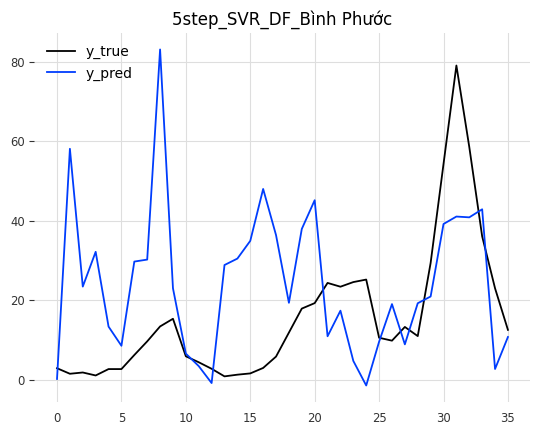

rmse,mae,mape,mse
24.46355332437375,18.656953016715853,5.745002923000081,598.4654412544779
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,max_iter,kernel,epsilon
0,Bình Phước,SVMRBF,21.186220,1,86,rbf,4.843055e-05
1,An Giang,SVMRBF,10.530370,1,102,rbf,4.604567e-02
2,Quảng Ninh,SVMRBF,2.170007,1,133,rbf,2.644738e-08


,Total_Evaporation,Total_Rainfall,Max_Daily_Rainfall,n_raining_days,Average_temperature,Max_Average_Temperature,Min_Average_Temperature,Max_Absolute_Temperature,Min_Absolute_Temperature,Average_Humidity,Min_Humidity,n_hours_sunshine,Dengue_fever_rates,year_month
1,0.511494,0.435286,0.344948,0.560976,0.403226,0.104478,0.479452,0.3750,0.582524,0.55,0.684211,0.320,4.040310,2013-06-30
2,0.511494,0.465940,0.414634,0.560976,0.467742,0.238806,0.438356,0.4000,0.553398,0.45,0.526316,0.390,5.387080,2013-07-31
3,0.494253,1.000000,0.401568,0.560976,0.596774,0.447761,0.589041,0.3750,0.689320,0.35,0.578947,0.695,6.269447,2013-08-31
4,0.275862,0.000000,0.493031,0.560976,0.532258,0.223881,0.493151,0.5500,0.611650,0.45,0.605263,0.440,6.501649,2013-09-30
5,0.465517,0.474796,0.475610,0.560976,0.548387,0.388060,0.479452,0.3125,0.524272,0.35,0.394737,0.830,6.315887,2013-10-31
6,0.500000,0.354905,0.244774,0.560976,0.612903,0.388060,0.534247,0.4125,0.660194,0.25,0.394737,0.650,9.706033,2013-11-30
7,0.574713,0.453678,0.523519,0.560976,0.161290,0.029851,0.150685,0.4000,0.165048,0.25,0.552632,0.610,9.055868,2013-12-31
8,0.402299,0.435286,0.275261,0.560976,0.532258,0.447761,0.136986,0.4125,0.417476,0.25,0.236842,0.625,4.545876,2014-01-31
9,0.327586,0.464578,0.423345,0.560976,0.725807,0.582090,0.890411,0.6250,0.912621,0.50,0.763158,0.590,2.180165,2014-02-28
10,0.568966,0.465259,0.427700,1.268293,0.903226,0.731343,0.808219,0.8000,0.737864,0.25,0.315790,0.670,1.994619,2014-03-31


🐹Len(prediction): 36
mean_squared_error: 133.6719
rmse: 11.561657515212444
mape: 1.481979350819105


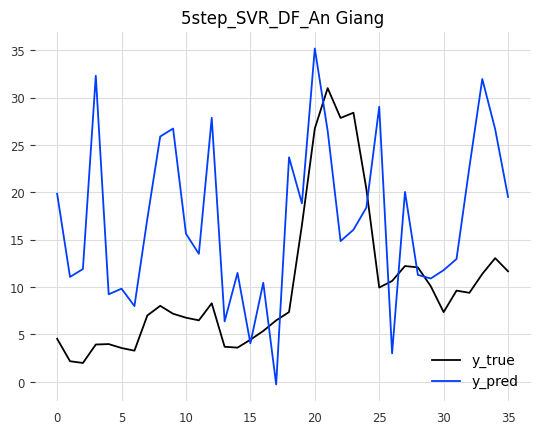

rmse,mae,mape,mse
11.561657515212444,9.518758792835477,1.481979350819105,133.67192449906838
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,max_iter,kernel,epsilon
0,Bình Phước,SVMRBF,21.186220,1,86,rbf,4.843055e-05
1,An Giang,SVMRBF,10.530370,1,102,rbf,4.604567e-02
2,Quảng Ninh,SVMRBF,2.170007,1,133,rbf,2.644738e-08


,Total_Evaporation,Total_Rainfall,Max_Daily_Rainfall,n_raining_days,Average_temperature,Max_Average_Temperature,Min_Average_Temperature,Max_Absolute_Temperature,Min_Absolute_Temperature,Average_Humidity,Min_Humidity,n_hours_sunshine,Dengue_fever_rates,year_month
1,0.643169,0.500318,0.551607,0.585366,0.579196,0.554585,0.613035,0.536817,0.531457,0.242912,0.121547,0.639314,0.842105,2013-06-30
2,0.308721,0.860821,0.576988,0.585366,0.468085,0.419214,0.547862,0.422803,0.698676,0.609626,0.834254,0.387018,0.842105,2013-07-31
3,0.573707,0.160052,0.607445,0.585366,0.536643,0.602620,0.558045,0.726841,0.599338,0.325718,0.226519,0.710349,0.926316,2013-08-31
4,0.493954,0.486828,0.476311,0.585366,0.401891,0.375546,0.486762,0.458432,0.425497,0.349377,0.281768,0.450704,2.442105,2013-09-30
5,0.872138,0.158179,0.430626,0.585366,0.392435,0.480349,0.395112,0.522565,0.314570,0.077299,0.143646,0.680955,1.852632,2013-10-31
6,0.246977,0.653588,0.863790,0.585366,0.286052,0.211790,0.466395,0.434679,0.509934,0.491331,0.491713,0.315983,0.926316,2013-11-30
7,0.529972,0.378527,0.302030,0.585366,0.000000,0.144105,0.000000,0.118765,0.157285,0.219253,0.237569,0.794856,1.431579,2013-12-31
8,0.447132,0.477459,0.535533,0.975610,0.602837,0.561135,0.655805,0.539192,0.582781,0.562308,0.381215,0.489896,0.000000,2014-01-31
9,0.206329,0.547911,0.604907,0.939024,0.529551,0.355895,0.665988,0.676960,0.637417,0.656944,0.607735,0.161666,0.250125,2014-02-28
10,0.308721,0.560277,0.603215,0.646342,0.728132,0.668122,0.778004,0.676960,0.892384,0.692433,0.933702,0.471525,0.000000,2014-03-31


🐹Len(prediction): 36
mean_squared_error: 6.8489
rmse: 2.6170486540952687
mape: 2369739970490877.5


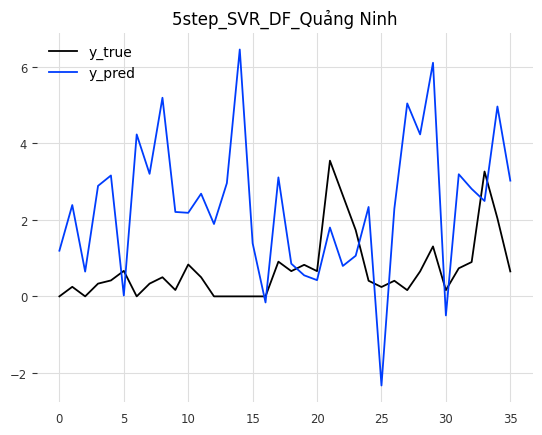

rmse,mae,mape,mse
2.6170486540952687,2.170089607490622,2369739970490877.5,6.848943657901858
✨✨✨✨✨✨✨✨6✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨PoissonRegressor✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,max_iter,fit_intercept,alpha
0,Bình Phước,PoissonRegressor,15.521014,1,82,False,0.000077
1,An Giang,PoissonRegressor,10.001899,1,194,False,0.001070
2,Quảng Ninh,PoissonRegressor,1.921663,1,110,False,0.000131


,Total_Evaporation,Total_Rainfall,Max_Daily_Rainfall,n_raining_days,Average_temperature,Max_Average_Temperature,Min_Average_Temperature,Max_Absolute_Temperature,Min_Absolute_Temperature,Average_Humidity,Min_Humidity,n_hours_sunshine,Dengue_fever_rates,year_month
0,0.002217,0.646375,0.553526,0.500000,0.423077,0.229508,0.310811,0.215385,0.476635,0.560976,0.700,0.677570,15.097209,2013-05-31
1,0.719143,0.475766,0.491711,0.500000,0.397436,0.360656,0.432432,0.461539,0.532710,0.536585,0.700,0.112149,29.977191,2013-06-30
2,0.630451,0.661884,0.508570,0.500000,0.448718,0.409836,0.324324,0.569231,0.448598,0.487805,0.475,0.457944,42.250462,2013-07-31
3,0.549150,0.465103,0.553526,0.500000,0.487179,0.590164,0.364865,0.384615,0.523365,0.487805,0.475,0.014019,31.280547,2013-08-31
4,0.475240,0.380768,0.331554,0.500000,0.474359,0.377049,0.472973,0.615385,0.570094,0.536585,0.650,0.836449,24.003476,2013-09-30
5,0.778270,0.670609,0.764260,0.500000,0.576923,0.704918,0.351351,0.507692,0.401869,0.365854,0.325,0.906542,13.033561,2013-10-31
6,0.652624,0.138426,0.140489,0.500000,0.474359,0.573770,0.297297,0.569231,0.383178,0.292683,0.575,0.500000,10.861301,2013-11-30
7,0.793053,0.501939,0.438325,0.500000,0.307692,0.377049,0.162162,0.476923,0.289720,0.414634,0.300,0.542056,9.666558,2013-12-31
8,0.688101,0.408879,0.463613,0.500000,0.461539,0.622951,0.243243,0.692308,0.383178,0.219512,0.275,0.771028,2.895442,2014-01-31
9,0.461936,0.499031,0.483282,0.500000,0.717949,0.885246,0.554054,0.738461,0.644860,0.634146,0.575,0.322430,1.501340,2014-02-28


🐹Len(prediction): 36
mean_squared_error: 319.2980
rmse: 17.8689129103564
mape: 3.787199966224682


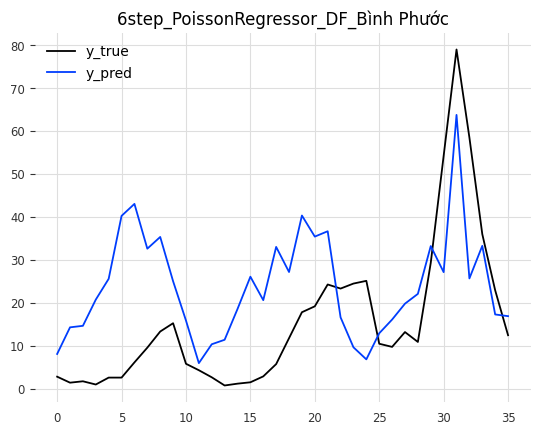

rmse,mae,mape,mse
17.8689129103564,15.134615226550608,3.787199966224682,319.29804859790164
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,max_iter,fit_intercept,alpha
0,Bình Phước,PoissonRegressor,15.521014,1,82,False,0.000077
1,An Giang,PoissonRegressor,10.001899,1,194,False,0.001070
2,Quảng Ninh,PoissonRegressor,1.921663,1,110,False,0.000131


,Total_Evaporation,Total_Rainfall,Max_Daily_Rainfall,n_raining_days,Average_temperature,Max_Average_Temperature,Min_Average_Temperature,Max_Absolute_Temperature,Min_Absolute_Temperature,Average_Humidity,Min_Humidity,n_hours_sunshine,Dengue_fever_rates,year_month
0,0.229885,0.535422,0.580139,0.560976,0.564516,0.283582,0.520548,0.3000,0.572816,0.55,0.578947,0.710,4.040310,2013-05-31
1,0.511494,0.435286,0.344948,0.560976,0.403226,0.104478,0.479452,0.3750,0.582524,0.55,0.684211,0.320,4.040310,2013-06-30
2,0.511494,0.465940,0.414634,0.560976,0.467742,0.238806,0.438356,0.4000,0.553398,0.45,0.526316,0.390,5.387080,2013-07-31
3,0.494253,1.000000,0.401568,0.560976,0.596774,0.447761,0.589041,0.3750,0.689320,0.35,0.578947,0.695,6.269447,2013-08-31
4,0.275862,0.000000,0.493031,0.560976,0.532258,0.223881,0.493151,0.5500,0.611650,0.45,0.605263,0.440,6.501649,2013-09-30
5,0.465517,0.474796,0.475610,0.560976,0.548387,0.388060,0.479452,0.3125,0.524272,0.35,0.394737,0.830,6.315887,2013-10-31
6,0.500000,0.354905,0.244774,0.560976,0.612903,0.388060,0.534247,0.4125,0.660194,0.25,0.394737,0.650,9.706033,2013-11-30
7,0.574713,0.453678,0.523519,0.560976,0.161290,0.029851,0.150685,0.4000,0.165048,0.25,0.552632,0.610,9.055868,2013-12-31
8,0.402299,0.435286,0.275261,0.560976,0.532258,0.447761,0.136986,0.4125,0.417476,0.25,0.236842,0.625,4.545876,2014-01-31
9,0.327586,0.464578,0.423345,0.560976,0.725807,0.582090,0.890411,0.6250,0.912621,0.50,0.763158,0.590,2.180165,2014-02-28


🐹Len(prediction): 36
mean_squared_error: 226.1430
rmse: 15.038052852458115
mape: 2.4097417914292305


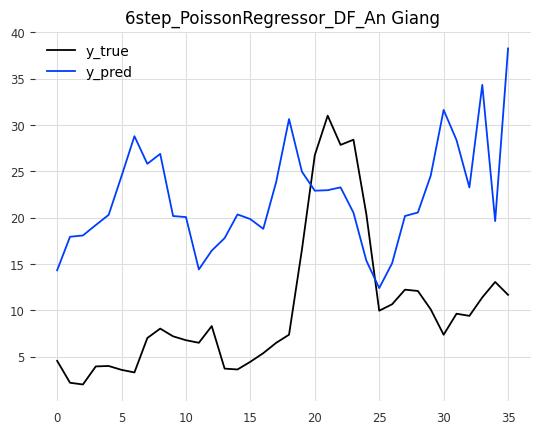

rmse,mae,mape,mse
15.038052852458115,13.559567440853462,2.4097417914292305,226.14303359332365
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,max_iter,fit_intercept,alpha
0,Bình Phước,PoissonRegressor,15.521014,1,82,False,0.000077
1,An Giang,PoissonRegressor,10.001899,1,194,False,0.001070
2,Quảng Ninh,PoissonRegressor,1.921663,1,110,False,0.000131


,Total_Evaporation,Total_Rainfall,Max_Daily_Rainfall,n_raining_days,Average_temperature,Max_Average_Temperature,Min_Average_Temperature,Max_Absolute_Temperature,Min_Absolute_Temperature,Average_Humidity,Min_Humidity,n_hours_sunshine,Dengue_fever_rates,year_month
0,0.602007,0.852576,0.788494,0.585366,0.770686,0.803493,0.743381,0.862233,0.837748,0.361207,0.530387,0.864666,0.673684,2013-05-31
1,0.643169,0.500318,0.551607,0.585366,0.579196,0.554585,0.613035,0.536817,0.531457,0.242912,0.121547,0.639314,0.842105,2013-06-30
2,0.308721,0.860821,0.576988,0.585366,0.468085,0.419214,0.547862,0.422803,0.698676,0.609626,0.834254,0.387018,0.842105,2013-07-31
3,0.573707,0.160052,0.607445,0.585366,0.536643,0.602620,0.558045,0.726841,0.599338,0.325718,0.226519,0.710349,0.926316,2013-08-31
4,0.493954,0.486828,0.476311,0.585366,0.401891,0.375546,0.486762,0.458432,0.425497,0.349377,0.281768,0.450704,2.442105,2013-09-30
5,0.872138,0.158179,0.430626,0.585366,0.392435,0.480349,0.395112,0.522565,0.314570,0.077299,0.143646,0.680955,1.852632,2013-10-31
6,0.246977,0.653588,0.863790,0.585366,0.286052,0.211790,0.466395,0.434679,0.509934,0.491331,0.491713,0.315983,0.926316,2013-11-30
7,0.529972,0.378527,0.302030,0.585366,0.000000,0.144105,0.000000,0.118765,0.157285,0.219253,0.237569,0.794856,1.431579,2013-12-31
8,0.447132,0.477459,0.535533,0.975610,0.602837,0.561135,0.655805,0.539192,0.582781,0.562308,0.381215,0.489896,0.000000,2014-01-31
9,0.206329,0.547911,0.604907,0.939024,0.529551,0.355895,0.665988,0.676960,0.637417,0.656944,0.607735,0.161666,0.250125,2014-02-28


🐹Len(prediction): 36
mean_squared_error: 4.2863
rmse: 2.0703380737116053
mape: 1730124975936794.2


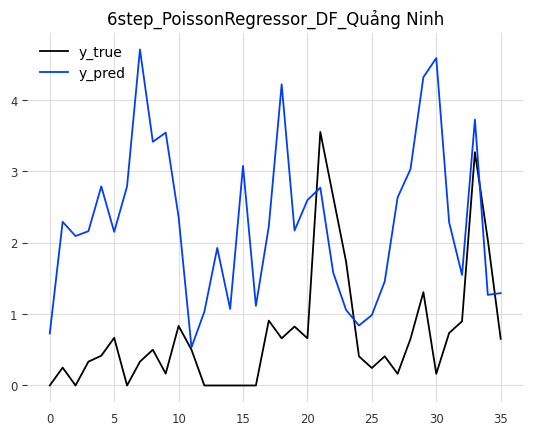

rmse,mae,mape,mse
2.0703380737116053,1.7502433234022245,1730124975936794.2,4.2862997394598805
✨✨✨✨✨✨✨✨SVMRBF✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨Bình Phước✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,max_iter,kernel,epsilon
0,Bình Phước,SVMRBF,21.599812,1,165,rbf,0.000147
1,An Giang,SVMRBF,11.023352,1,101,rbf,0.000001
2,Quảng Ninh,SVMRBF,1.979847,1,200,rbf,0.000147


,Total_Evaporation,Total_Rainfall,Max_Daily_Rainfall,n_raining_days,Average_temperature,Max_Average_Temperature,Min_Average_Temperature,Max_Absolute_Temperature,Min_Absolute_Temperature,Average_Humidity,Min_Humidity,n_hours_sunshine,Dengue_fever_rates,year_month
0,0.002217,0.646375,0.553526,0.500000,0.423077,0.229508,0.310811,0.215385,0.476635,0.560976,0.700,0.677570,15.097209,2013-05-31
1,0.719143,0.475766,0.491711,0.500000,0.397436,0.360656,0.432432,0.461539,0.532710,0.536585,0.700,0.112149,29.977191,2013-06-30
2,0.630451,0.661884,0.508570,0.500000,0.448718,0.409836,0.324324,0.569231,0.448598,0.487805,0.475,0.457944,42.250462,2013-07-31
3,0.549150,0.465103,0.553526,0.500000,0.487179,0.590164,0.364865,0.384615,0.523365,0.487805,0.475,0.014019,31.280547,2013-08-31
4,0.475240,0.380768,0.331554,0.500000,0.474359,0.377049,0.472973,0.615385,0.570094,0.536585,0.650,0.836449,24.003476,2013-09-30
5,0.778270,0.670609,0.764260,0.500000,0.576923,0.704918,0.351351,0.507692,0.401869,0.365854,0.325,0.906542,13.033561,2013-10-31
6,0.652624,0.138426,0.140489,0.500000,0.474359,0.573770,0.297297,0.569231,0.383178,0.292683,0.575,0.500000,10.861301,2013-11-30
7,0.793053,0.501939,0.438325,0.500000,0.307692,0.377049,0.162162,0.476923,0.289720,0.414634,0.300,0.542056,9.666558,2013-12-31
8,0.688101,0.408879,0.463613,0.500000,0.461539,0.622951,0.243243,0.692308,0.383178,0.219512,0.275,0.771028,2.895442,2014-01-31
9,0.461936,0.499031,0.483282,0.500000,0.717949,0.885246,0.554054,0.738461,0.644860,0.634146,0.575,0.322430,1.501340,2014-02-28


🐹Len(prediction): 36
mean_squared_error: 522.0366
rmse: 22.848121087523136
mape: 3.4826763061528525


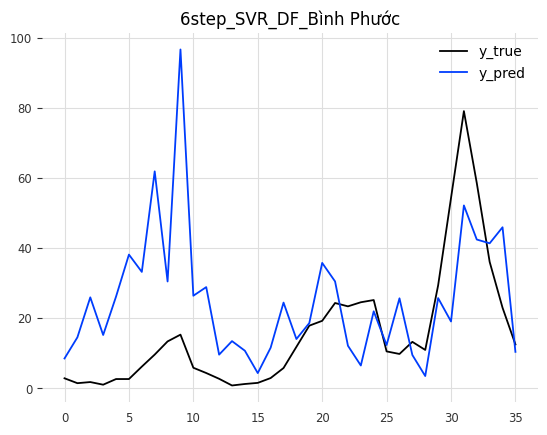

rmse,mae,mape,mse
22.848121087523136,16.578462368886637,3.4826763061528525,522.0366372301195
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,max_iter,kernel,epsilon
0,Bình Phước,SVMRBF,21.599812,1,165,rbf,0.000147
1,An Giang,SVMRBF,11.023352,1,101,rbf,0.000001
2,Quảng Ninh,SVMRBF,1.979847,1,200,rbf,0.000147


,Total_Evaporation,Total_Rainfall,Max_Daily_Rainfall,n_raining_days,Average_temperature,Max_Average_Temperature,Min_Average_Temperature,Max_Absolute_Temperature,Min_Absolute_Temperature,Average_Humidity,Min_Humidity,n_hours_sunshine,Dengue_fever_rates,year_month
0,0.229885,0.535422,0.580139,0.560976,0.564516,0.283582,0.520548,0.3000,0.572816,0.55,0.578947,0.710,4.040310,2013-05-31
1,0.511494,0.435286,0.344948,0.560976,0.403226,0.104478,0.479452,0.3750,0.582524,0.55,0.684211,0.320,4.040310,2013-06-30
2,0.511494,0.465940,0.414634,0.560976,0.467742,0.238806,0.438356,0.4000,0.553398,0.45,0.526316,0.390,5.387080,2013-07-31
3,0.494253,1.000000,0.401568,0.560976,0.596774,0.447761,0.589041,0.3750,0.689320,0.35,0.578947,0.695,6.269447,2013-08-31
4,0.275862,0.000000,0.493031,0.560976,0.532258,0.223881,0.493151,0.5500,0.611650,0.45,0.605263,0.440,6.501649,2013-09-30
5,0.465517,0.474796,0.475610,0.560976,0.548387,0.388060,0.479452,0.3125,0.524272,0.35,0.394737,0.830,6.315887,2013-10-31
6,0.500000,0.354905,0.244774,0.560976,0.612903,0.388060,0.534247,0.4125,0.660194,0.25,0.394737,0.650,9.706033,2013-11-30
7,0.574713,0.453678,0.523519,0.560976,0.161290,0.029851,0.150685,0.4000,0.165048,0.25,0.552632,0.610,9.055868,2013-12-31
8,0.402299,0.435286,0.275261,0.560976,0.532258,0.447761,0.136986,0.4125,0.417476,0.25,0.236842,0.625,4.545876,2014-01-31
9,0.327586,0.464578,0.423345,0.560976,0.725807,0.582090,0.890411,0.6250,0.912621,0.50,0.763158,0.590,2.180165,2014-02-28


🐹Len(prediction): 36
mean_squared_error: 128.5925
rmse: 11.339862715086454
mape: 1.245868415923434


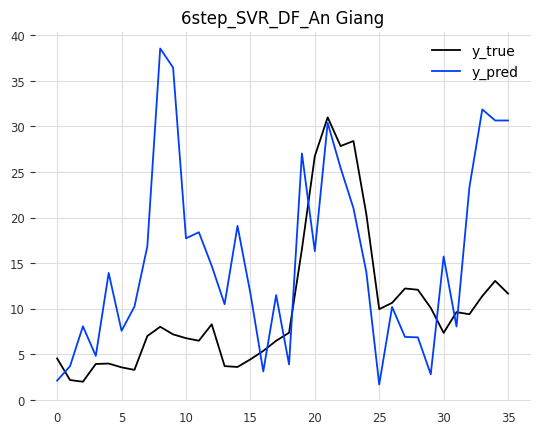

rmse,mae,mape,mse
11.339862715086454,8.778979306550546,1.245868415923434,128.59248639700792
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,max_iter,kernel,epsilon
0,Bình Phước,SVMRBF,21.599812,1,165,rbf,0.000147
1,An Giang,SVMRBF,11.023352,1,101,rbf,0.000001
2,Quảng Ninh,SVMRBF,1.979847,1,200,rbf,0.000147


,Total_Evaporation,Total_Rainfall,Max_Daily_Rainfall,n_raining_days,Average_temperature,Max_Average_Temperature,Min_Average_Temperature,Max_Absolute_Temperature,Min_Absolute_Temperature,Average_Humidity,Min_Humidity,n_hours_sunshine,Dengue_fever_rates,year_month
0,0.602007,0.852576,0.788494,0.585366,0.770686,0.803493,0.743381,0.862233,0.837748,0.361207,0.530387,0.864666,0.673684,2013-05-31
1,0.643169,0.500318,0.551607,0.585366,0.579196,0.554585,0.613035,0.536817,0.531457,0.242912,0.121547,0.639314,0.842105,2013-06-30
2,0.308721,0.860821,0.576988,0.585366,0.468085,0.419214,0.547862,0.422803,0.698676,0.609626,0.834254,0.387018,0.842105,2013-07-31
3,0.573707,0.160052,0.607445,0.585366,0.536643,0.602620,0.558045,0.726841,0.599338,0.325718,0.226519,0.710349,0.926316,2013-08-31
4,0.493954,0.486828,0.476311,0.585366,0.401891,0.375546,0.486762,0.458432,0.425497,0.349377,0.281768,0.450704,2.442105,2013-09-30
5,0.872138,0.158179,0.430626,0.585366,0.392435,0.480349,0.395112,0.522565,0.314570,0.077299,0.143646,0.680955,1.852632,2013-10-31
6,0.246977,0.653588,0.863790,0.585366,0.286052,0.211790,0.466395,0.434679,0.509934,0.491331,0.491713,0.315983,0.926316,2013-11-30
7,0.529972,0.378527,0.302030,0.585366,0.000000,0.144105,0.000000,0.118765,0.157285,0.219253,0.237569,0.794856,1.431579,2013-12-31
8,0.447132,0.477459,0.535533,0.975610,0.602837,0.561135,0.655805,0.539192,0.582781,0.562308,0.381215,0.489896,0.000000,2014-01-31
9,0.206329,0.547911,0.604907,0.939024,0.529551,0.355895,0.665988,0.676960,0.637417,0.656944,0.607735,0.161666,0.250125,2014-02-28


🐹Len(prediction): 36
mean_squared_error: 7.1904
rmse: 2.6814832691543153
mape: 2281861067911072.5


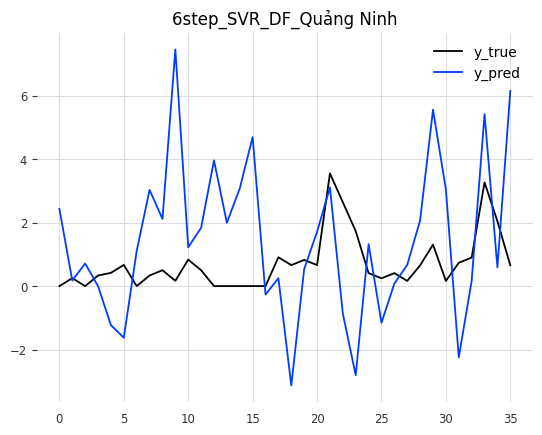

rmse,mae,mape,mse
2.6814832691543153,2.075135368656385,2281861067911072.5,7.190352522754515


In [154]:
model_name_list = [
    #  "RandomForest",
    #  "LinearRegressionModel",
    #  "LightGBMModel",
    #  "CatBoostModel",
    #  "XGBModel",
    "PoissonRegressor",
    "SVMRBF"
]

for nstep in range(1,args.n_predicted_period_months+1):
# for nstep in range(1,2):
    print(f"✨✨✨✨✨✨✨✨{nstep}✨✨✨✨✨✨✨✨✨✨")
    for model_name in model_name_list:   
        print(f"✨✨✨✨✨✨✨✨{model_name}✨✨✨✨✨✨✨✨✨✨")
        for city in cities:
            print(f"✨✨✨✨✨✨✨✨{city}✨✨✨✨✨✨✨✨✨✨")
            df_train = pd.read_csv(output_process+city+'_train_preprocessed.csv', parse_dates=True, index_col= None, encoding = 'unicode_escape')
            df_valid = pd.read_csv(output_process+city+'_test_preprocessed.csv', parse_dates=True, index_col= None, encoding = 'unicode_escape')
            scaler = joblib.load(output_process+city+'_train_scalerMinMaxNorm.save') #ok

            selected_features = getDataWithSelectedFeature(city, nstep)

            lags_by_nstep = args.look_back + nstep - 1
            lags_past_covariates_by_nstep = [-lags_by_nstep+2,-lags_by_nstep+1,-lags_by_nstep] #Mảng này chứa ba giá trị tương ứng cho args.lookback 3
            is_dl_algo = 0

            pl_trainer_kwargs = {
                        "accelerator": "cpu",
                        # "devices": -1,
                        # "auto_select_gpus": True,
                    }

            df_hyper_params = getHyperParams(model_name, city, nstep)

            if model_name == "RandomForest":
                    lags = df_hyper_params['lags'].values[0]
                    lags_past_covariates = df_hyper_params['lags_past_covariates'].values[0].split(',')
                    lags_past_covariates = [int(i) for i in lags_past_covariates]
                    output_chunk_length = df_hyper_params['output_chunk_length'].values[0]
                    n_estimators = df_hyper_params['n_estimators'].values[0]
                    max_depth = df_hyper_params['max_depth'].values[0]
                    random_state = df_hyper_params['random_state'].values[0]
                    # Create the RandomForest model
                    model = RandomForest(
                                    lags = int(lags),
                                    lags_past_covariates = lags_past_covariates_by_nstep,
                                    output_chunk_length = int(output_chunk_length),
                                    n_estimators = int(n_estimators),
                                    max_depth = int(max_depth),
                                    random_state=int(random_state))
            elif model_name == 'XGBModel':
                    lags = df_hyper_params['lags'].values[0]
                    lags_past_covariates = df_hyper_params['lags_past_covariates'].values[0].split(',')
                    lags_past_covariates = [int(i) for i in lags_past_covariates]
                    output_chunk_length = df_hyper_params['output_chunk_length'].values[0]
                    random_state = df_hyper_params['random_state'].values[0]
                    likelihood = df_hyper_params['likelihood'].values[0]
                    # Create the  model
                    model = XGBModel(
                                    lags = int(lags),
                                    lags_past_covariates = lags_past_covariates,
                                    output_chunk_length = int(output_chunk_length),
                                    random_state=int(random_state),
                                    likelihood = likelihood
                                    )
            elif model_name == 'LinearRegressionModel':
                    lags = df_hyper_params['lags'].values[0]
                    lags_past_covariates = df_hyper_params['lags_past_covariates'].values[0].split(',')
                    lags_past_covariates = [int(i) for i in lags_past_covariates]
                    output_chunk_length = df_hyper_params['output_chunk_length'].values[0]
                    random_state = df_hyper_params['random_state'].values[0]
                    # Create the  model
                    model = LinearRegressionModel(
                                    lags = int(lags),
                                    lags_past_covariates = lags_past_covariates,
                                    output_chunk_length = int(output_chunk_length),
                                    random_state=int(random_state))
            elif model_name == "CatBoostModel":
                    lags = df_hyper_params['lags'].values[0]
                    lags_past_covariates = df_hyper_params['lags_past_covariates'].values[0].split(',')
                    lags_past_covariates = [int(i) for i in lags_past_covariates]
                    learning_rate = df_hyper_params['learning_rate'].values[0]
                    n_estimators = df_hyper_params['n_estimators'].values[0]
                    max_depth = df_hyper_params['max_depth'].values[0]
                    output_chunk_length = df_hyper_params['output_chunk_length'].values[0]
                    likelihood = df_hyper_params['likelihood'].values[0]
                    bagging_temperature = df_hyper_params['bagging_temperature'].values[0]
                    border_count = df_hyper_params['border_count'].values[0]
                    l2_leaf_reg = df_hyper_params['l2_leaf_reg'].values[0]
                    random_strength = df_hyper_params['random_strength'].values[0]
                    opt_quantitles = df_hyper_params['quantiles'].values[0]
                    if opt_quantitles == "IsNone":
                        quantitles = None
                    else:
                        quantitles = df_hyper_params['quantiles'].values[0].split(',')
                    model = CatBoostModel(
                                            lags=int(lags),
                                            lags_past_covariates=lags_past_covariates, 
                                            learning_rate=float(learning_rate),
                                            n_estimators= int(n_estimators),
                                            max_depth=int(max_depth), 
                                            output_chunk_length = int(output_chunk_length),
                                            likelihood = likelihood,
                                            # quantiles = float(quantiles), #None or float
                                            bagging_temperature = float(bagging_temperature),
                                            # border_count = int(border_count),
                                            l2_leaf_reg = float(l2_leaf_reg),
                                            random_strength = float(random_strength),
                                            random_state=int(random_state))
            elif model_name == "LightGBMModel":
                    lags = df_hyper_params['lags'].values[0]
                    lags_past_covariates = df_hyper_params['lags_past_covariates'].values[0].split(',')
                    lags_past_covariates = [int(i) for i in lags_past_covariates]
                    output_chunk_length = df_hyper_params['output_chunk_length'].values[0]
                    random_state = df_hyper_params['random_state'].values[0]
                    multi_models = df_hyper_params['multi_models'].values[0]
                    likelihood = df_hyper_params['likelihood'].values[0]
                    num_leaves = df_hyper_params['num_leaves'].values[0]
                    learning_rate = df_hyper_params['learning_rate'].values[0]
                    feature_fraction = df_hyper_params['feature_fraction'].values[0]
                    bagging_fraction = df_hyper_params['bagging_fraction'].values[0]
                    min_child_samples = df_hyper_params['min_child_samples'].values[0]
                    lambda_l1 = df_hyper_params['lambda_l1'].values[0]
                    verbose = df_hyper_params['verbose'].values[0]
                    model = LightGBMModel(
                        lags =int(lags),
                        lags_past_covariates = lags_past_covariates,
                        output_chunk_length = int(output_chunk_length),
                        random_state = int(random_state),
                        multi_models = bool(multi_models),
                        likelihood = likelihood,
                        num_leaves = int(num_leaves),
                        learning_rate = float(learning_rate),
                        feature_fraction = float(feature_fraction),
                        bagging_fraction = float(bagging_fraction),
                        min_child_samples = int(min_child_samples),
                        lambda_l1 = float(lambda_l1),
                        verbose = int(verbose)
                    )
            elif model_name == 'SVMRBF':
                    max_iter = df_hyper_params['max_iter'].values[0]
                    epsilon = df_hyper_params['epsilon'].values[0],
                    model = SVR(
                        max_iter = max_iter,
                        kernel = 'rbf',
                        epsilon = epsilon[0]
                    )
                    is_sklearn_model = 1
            elif model_name == "PoissonRegressor":
                    max_iter = df_hyper_params['max_iter'].values[0]
                    alpha = df_hyper_params['alpha'].values[0],
                    model = PoissonRegressor(
                        max_iter = max_iter,
                        fit_intercept = False,
                        alpha = alpha[0]
                    )
                    is_sklearn_model = 1        
            df, model = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
                                                            labels=args.labels, scaler=scaler, is_dl_algo = is_dl_algo,is_sklearn_model = is_sklearn_model, nstep = nstep)
            df.to_excel(f"./predict_results/0_train_{nstep}nstep_denguefever_prediction_results_by_{model_name}_in_{city}.xlsx")
            pickle.dump(model, open(f"./trained_models/{nstep}nstep_denguefever_{model_name}_in_{city}.sav", 'wb'))